In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import os
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

# Load the Data into Pandas DataFrame

In [2]:
# Database connection details
DB_NAME = "postgres"
DB_USER = "postgres"
DB_PASSWORD = "sky@2025"
DB_HOST = "localhost"
DB_PORT = "8089"

conn = psycopg2.connect(
    dbname=DB_NAME, user=DB_USER, password=DB_PASSWORD, host=DB_HOST, port=DB_PORT)

In [3]:
# Query from SQL and read into pandas DataFrame
query = """
SELECT time_stamp, tag_id, tag_value
FROM sensor_data_new
WHERE tag_id < 81
ORDER BY time_stamp, tag_id;
"""
df_raw = pd.read_sql_query(query, conn)
df_raw

C:\Users\dixshant.shreemal-st\AppData\Local\Temp\ipykernel_460\596154160.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_raw = pd.read_sql_query(query, conn)


time_stamp  tag_id  tag_value
0       2025-01-01 00:01:00       1      13.26
1       2025-01-01 00:01:00       2      83.00
2       2025-01-01 00:01:00       3     464.00
3       2025-01-01 00:01:00       4      -3.23
4       2025-01-01 00:01:00       5       0.00
...                     ...     ...        ...
7962642 2025-03-11 23:59:00      76      78.00
7962643 2025-03-11 23:59:00      77      77.70
7962644 2025-03-11 23:59:00      78     461.00
7962645 2025-03-11 23:59:00      79     463.00
7962646 2025-03-11 23:59:00      80     250.00

[7962647 rows x 3 columns]

In [4]:
# pivot the rows to have unique timestamps as index and tag_ids as columns
# and tag_values as the values in the table
df = df_raw.pivot(index='time_stamp', columns='tag_id', values='tag_value')
df.head()

tag_id                  1     2      3     4    5      6     7      8      9   \
time_stamp                                                                      
2025-01-01 00:01:00  13.26  83.0  464.0 -3.23  0.0  727.0  70.0   9.44   9.14   
2025-01-01 00:02:00  15.55  84.0  458.0 -3.08  0.0  735.0  70.0  11.00  10.88   
2025-01-01 00:03:00  17.96  84.0  453.0 -2.52  0.0  743.0  70.0  11.00  10.93   
2025-01-01 00:04:00  19.19  84.0  448.0 -2.12  0.0  751.0  70.0  11.00  10.99   
2025-01-01 00:05:00  19.30  83.0  443.0 -2.05  0.0  759.0  70.0  11.00  11.10   

tag_id                 10  ...      71    72   73    74    75    76    77  \
time_stamp                 ...                                              
2025-01-01 00:01:00  0.05  ...  1746.0  65.0  0.0  68.0  67.0  65.0  64.7   
2025-01-01 00:02:00  0.05  ...  1344.0  65.0  0.0  68.0  67.0  65.0  64.7   
2025-01-01 00:03:00  0.05  ...  1280.0  65.0  0.0  68.0  67.0  65.0  64.6   
2025-01-01 00:04:00  0.05  ...   957.0  65.0  0.0  68.0  67.0  65.0  64.6   
2025-01-01 00:05:00  0.05  ...   865.0  65.0  0.0  68.0  67.0  65.0  64.7   

tag_id                  78     79     80  
time_stamp                                
2025-01-01 00:01:00  419.0  385.0  393.0  
2025-01-01 00:02:00  419.0  383.0  392.0  
2025-01-01 00:03:00  418.0  383.0  394.0  
2025-01-01 00:04:00  418.0  385.0  397.0  
2025-01-01 00:05:00  417.0  387.0  400.0  

[5 rows x 79 columns]

In [5]:
# Rename the columns to be description_2 from Master Table
mapping_query = """
SELECT tag_id, description_2
FROM master_table
WHERE tag_id IN %s
"""

tag_ids = tuple(df.columns)
tag_ids
conn.rollback()
cur = conn.cursor()
cur.execute(mapping_query, (tag_ids,))
rows = cur.fetchall()
rows

# # Step 2: Build dictionary
tag_map = {tag_id: desc_2 for tag_id, desc_2 in rows}

# # Step 3: Rename pivot_df columns
df.rename(columns=tag_map, inplace=True)

# This code will give an error if run again becuase the columns in df are already renamed
# and tag_ids is a tuple of texts not integers



In [6]:
# remove special charecters in column names:
df.columns = [str(col).replace('/', '_').replace(':', '_').replace('\\', '_') for col in df.columns]

# Now pivot_df columns are readable descriptions
df
# df['Kiln Inlet O2'].describe()


Specific Air consumption  Clinker temperature  \
time_stamp                                                           
2025-01-01 00:01:00                     13.26                 83.0   
2025-01-01 00:02:00                     15.55                 84.0   
2025-01-01 00:03:00                     17.96                 84.0   
2025-01-01 00:04:00                     19.19                 84.0   
2025-01-01 00:05:00                     19.30                 83.0   
...                                       ...                  ...   
2025-03-11 23:55:00                      2.03                147.0   
2025-03-11 23:56:00                      2.03                147.0   
2025-03-11 23:57:00                      2.03                147.0   
2025-03-11 23:58:00                      2.02                147.0   
2025-03-11 23:59:00                      2.02                147.0   

                     Secondary Air Temperature  Kiln Hood Draft temperature  \
time_stamp                                                                    
2025-01-01 00:01:00                      464.0                        -3.23   
2025-01-01 00:02:00                      458.0                        -3.08   
2025-01-01 00:03:00                      453.0                        -2.52   
2025-01-01 00:04:00                      448.0                        -2.12   
2025-01-01 00:05:00                      443.0                        -2.05   
...                                        ...                          ...   
2025-03-11 23:55:00                      928.0                        -3.36   
2025-03-11 23:56:00                      924.0                        -3.63   
2025-03-11 23:57:00                      919.0                        -3.67   
2025-03-11 23:58:00                      915.0                        -4.22   
2025-03-11 23:59:00                      911.0                        -3.91   

                     TA Duct Draft  TA Duct Temperature  \
time_stamp                                                
2025-01-01 00:01:00            0.0                727.0   
2025-01-01 00:02:00            0.0                735.0   
2025-01-01 00:03:00            0.0                743.0   
2025-01-01 00:04:00            0.0                751.0   
2025-01-01 00:05:00            0.0                759.0   
...                            ...                  ...   
2025-03-11 23:55:00            0.0               1085.0   
2025-03-11 23:56:00            0.0               1087.0   
2025-03-11 23:57:00            0.0               1088.0   
2025-03-11 23:58:00            0.0               1090.0   
2025-03-11 23:59:00            0.0               1091.0   

                     Cooler vent Fan Speed (Cooler outlet Fan_ ESP Inlet Fan) PV  \
time_stamp                                                                         
2025-01-01 00:01:00                                               70.0             
2025-01-01 00:02:00                                               70.0             
2025-01-01 00:03:00                                               70.0             
2025-01-01 00:04:00                                               70.0             
2025-01-01 00:05:00                                               70.0             
...                                                                ...             
2025-03-11 23:55:00                                               94.0             
2025-03-11 23:56:00                                               94.0             
2025-03-11 23:57:00                                               94.0             
2025-03-11 23:58:00                                               94.0             
2025-03-11 23:59:00                                               94.0             

                     Kiln Coal SP  Coal Feed Rate (Calciner String)  \
time_stamp                                                            
2025-01-01 00:01:00          9.44                              9.14   
2025-01-

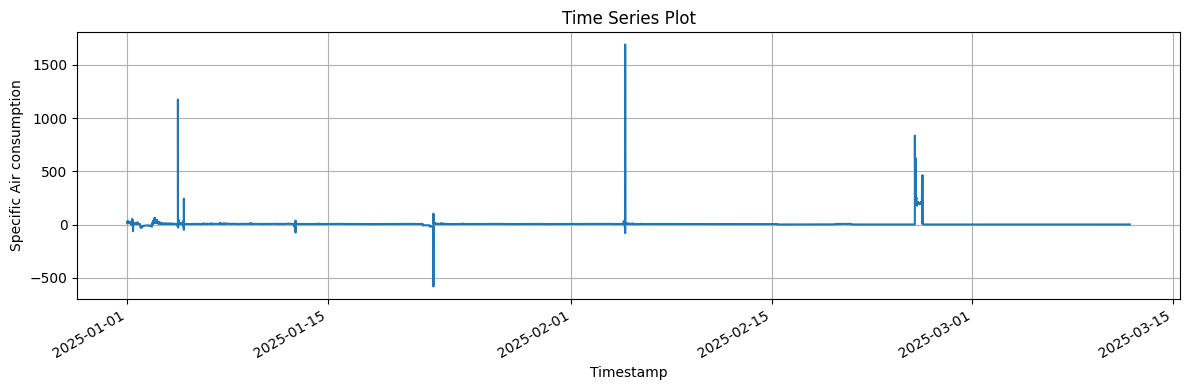

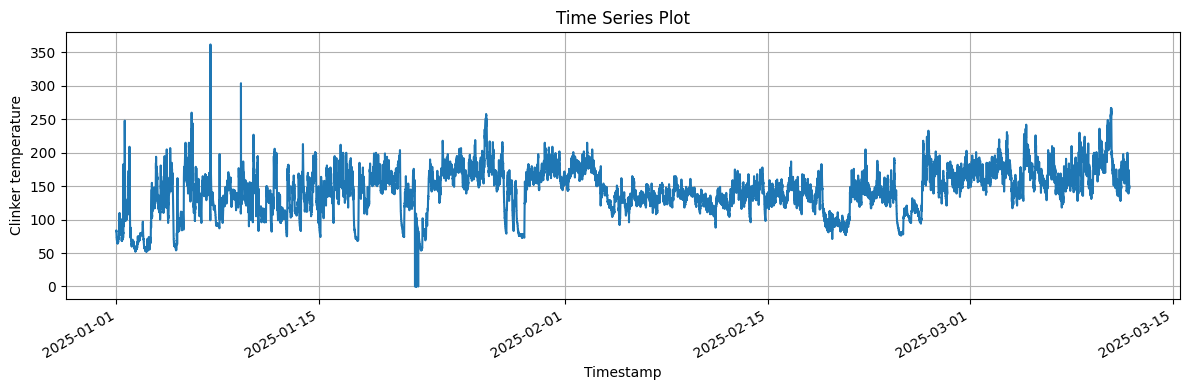

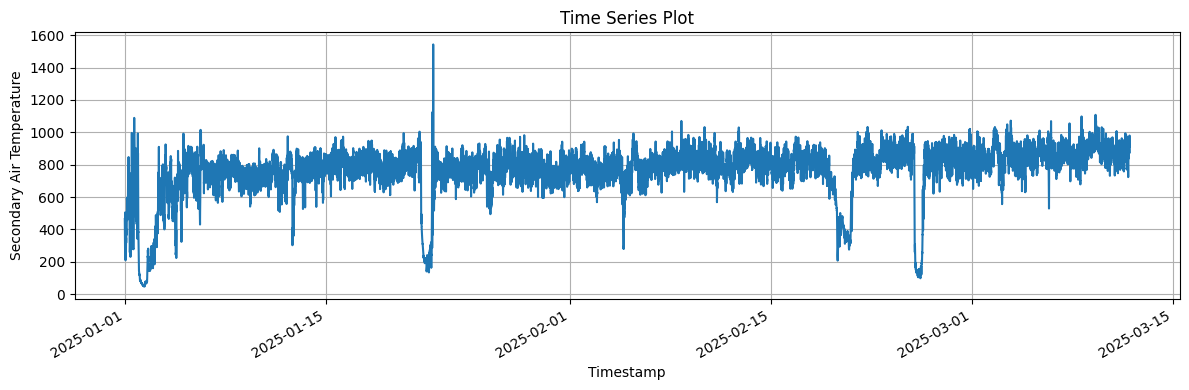

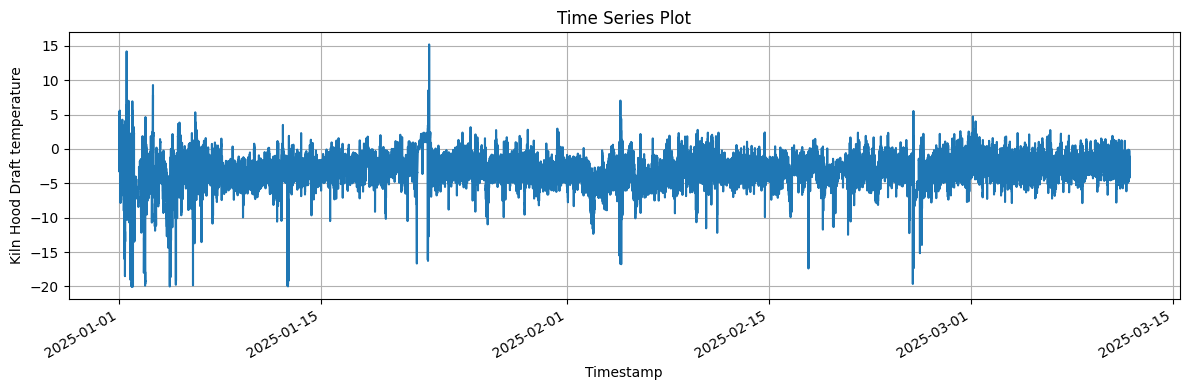

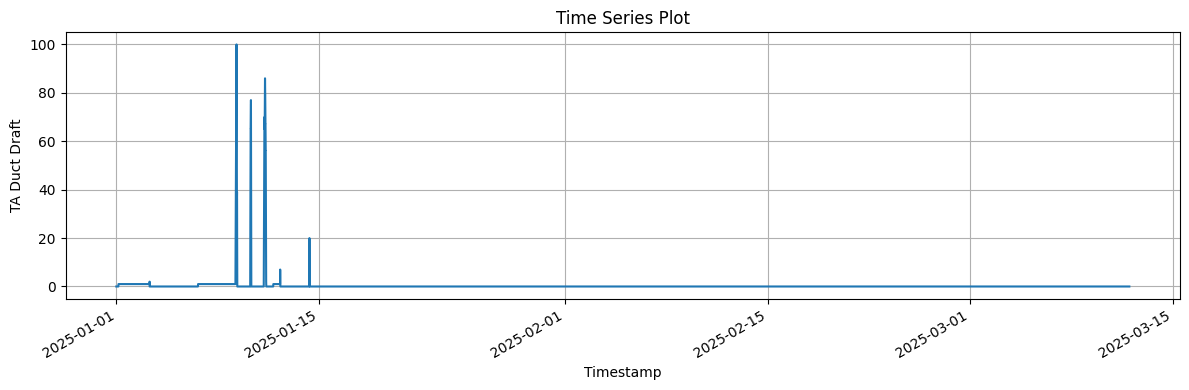

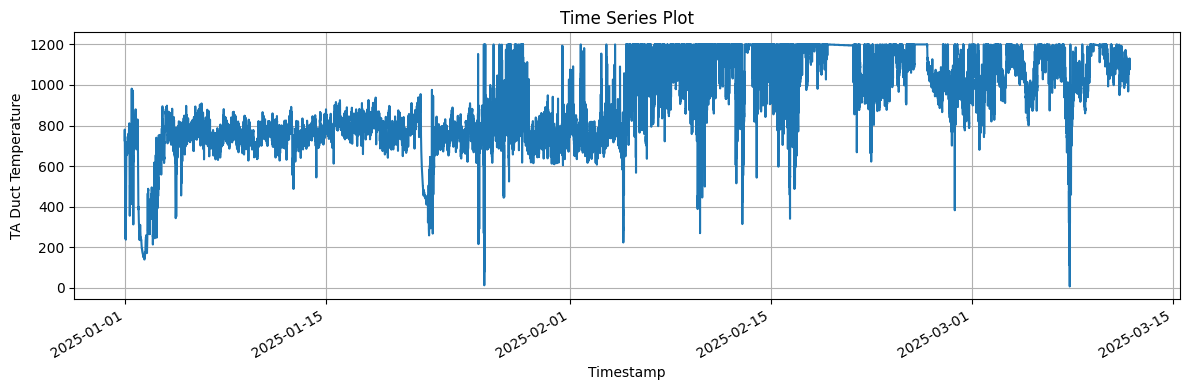

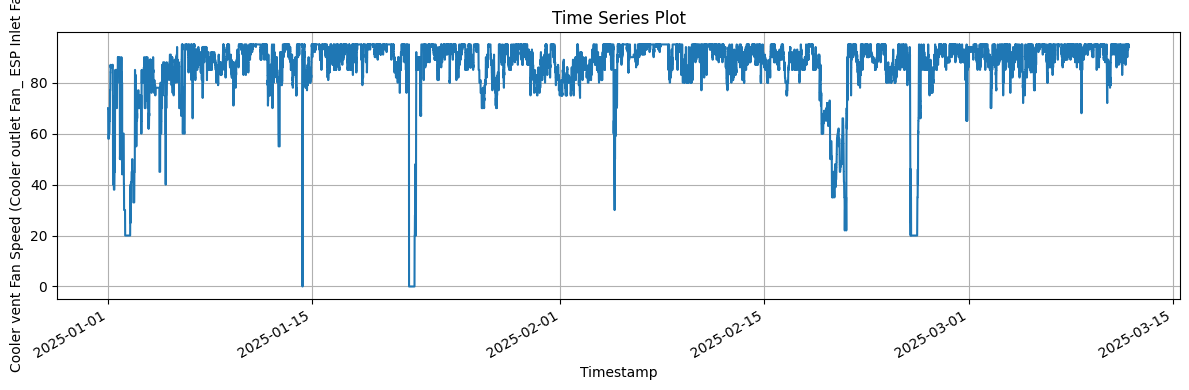

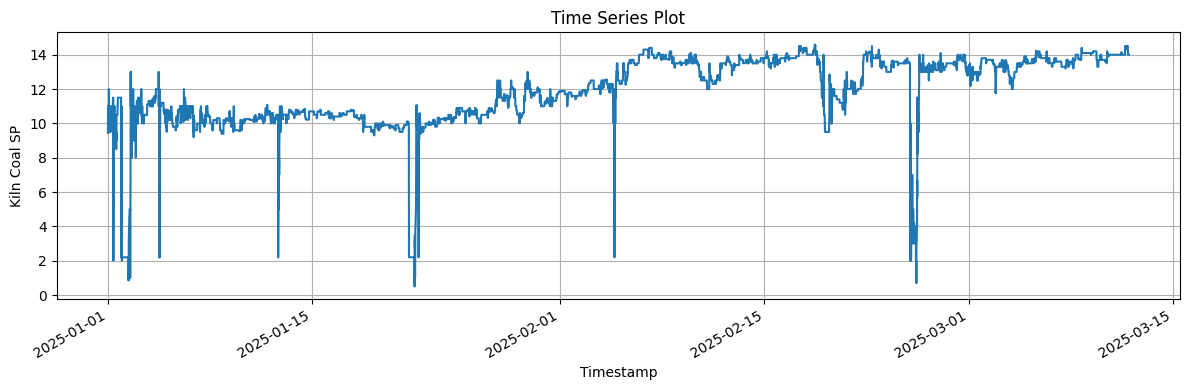

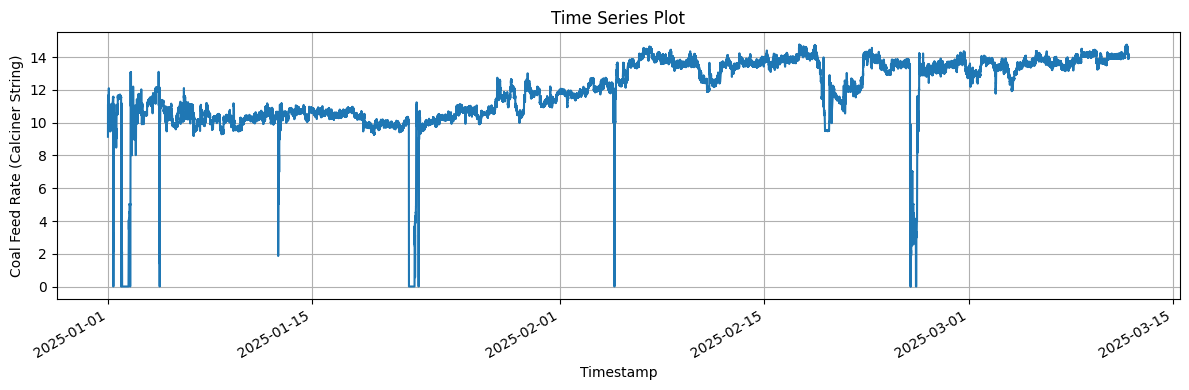

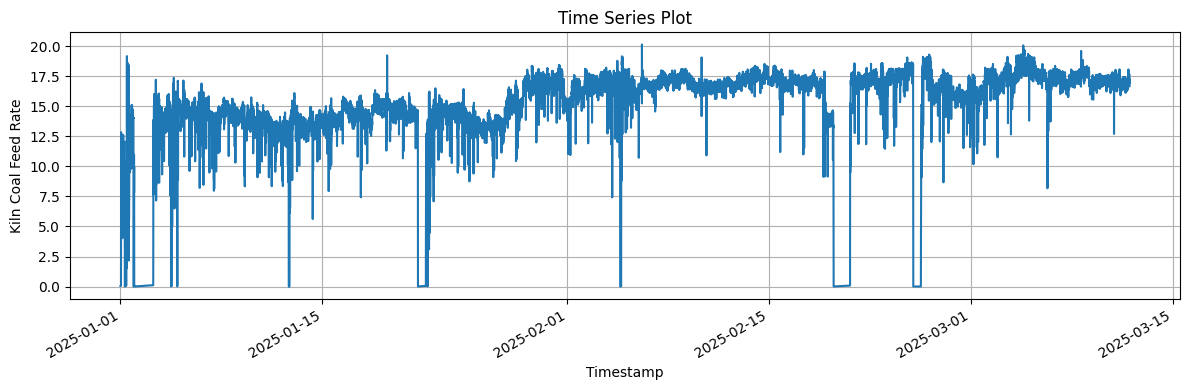

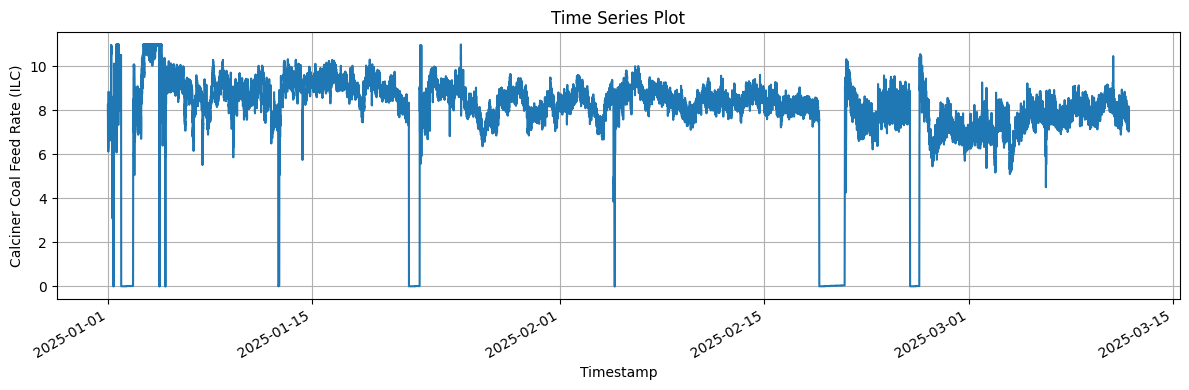

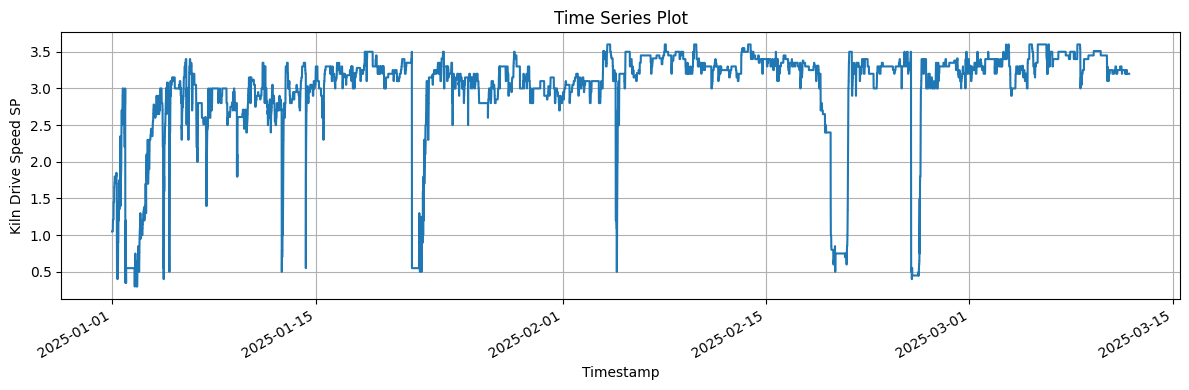

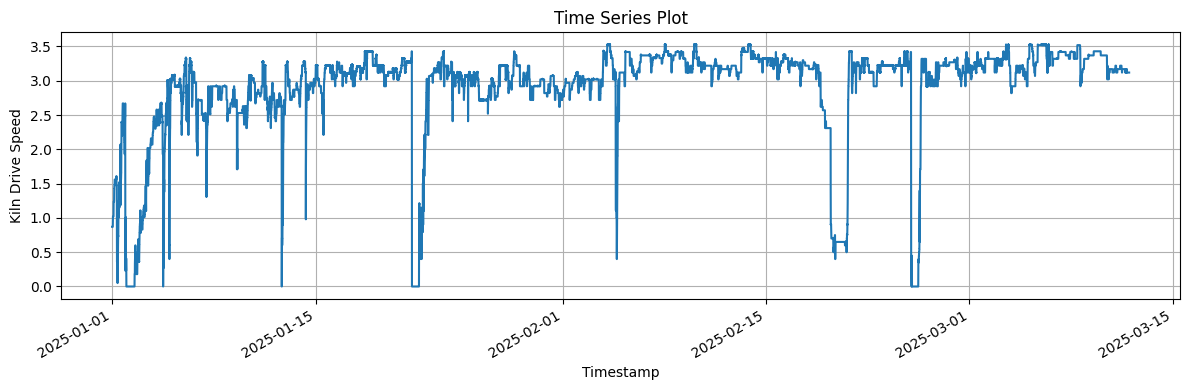

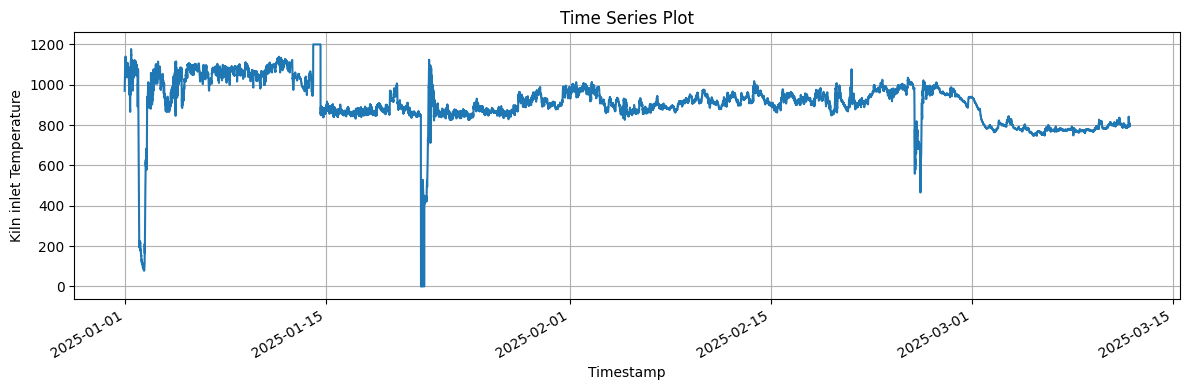

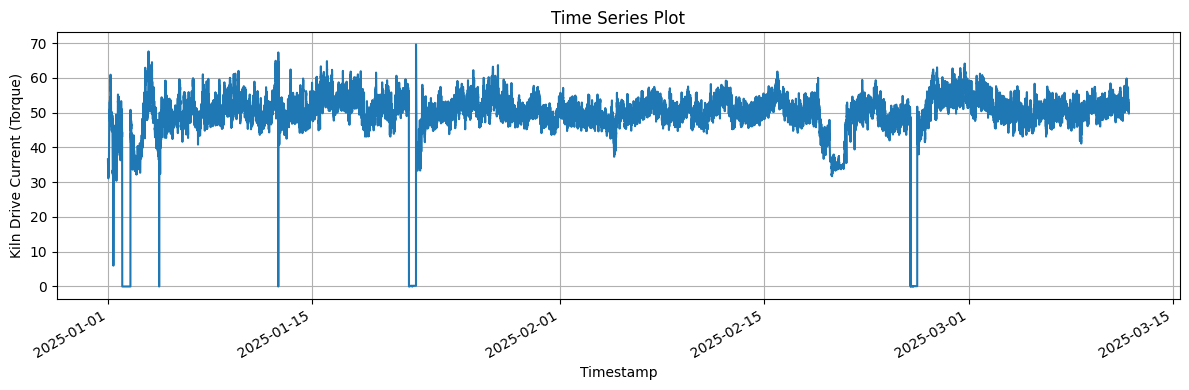

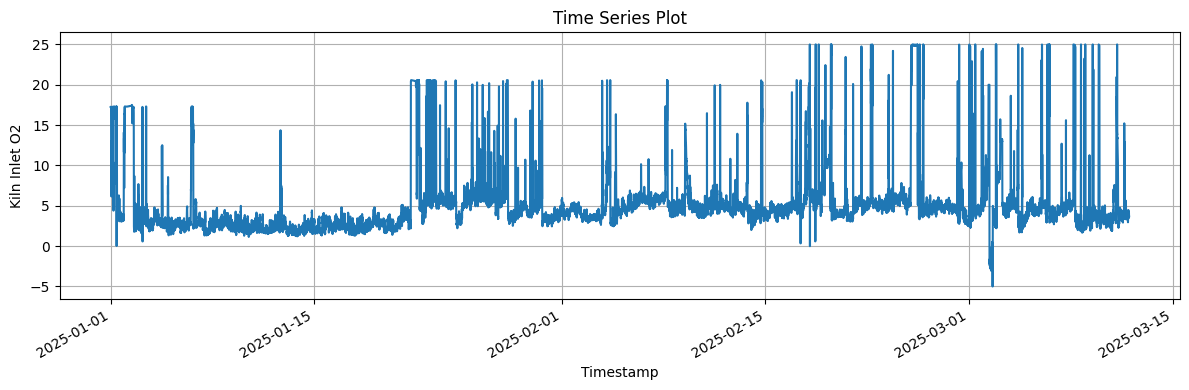

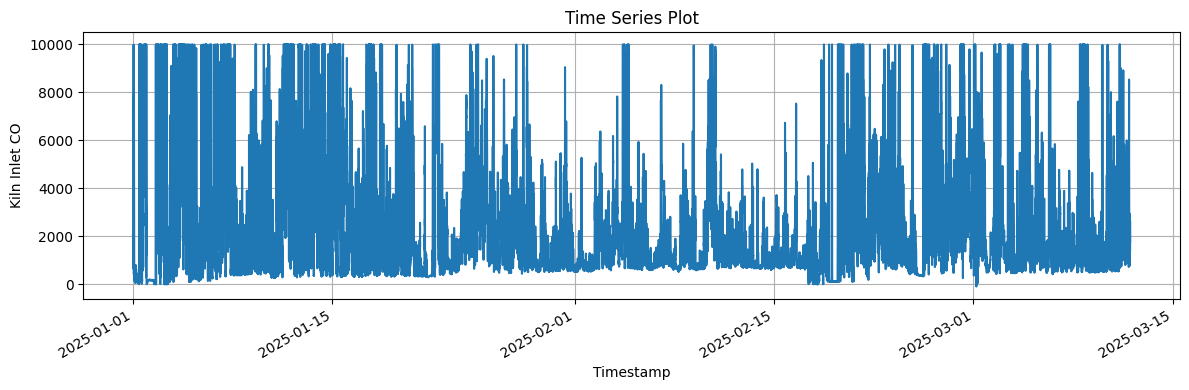

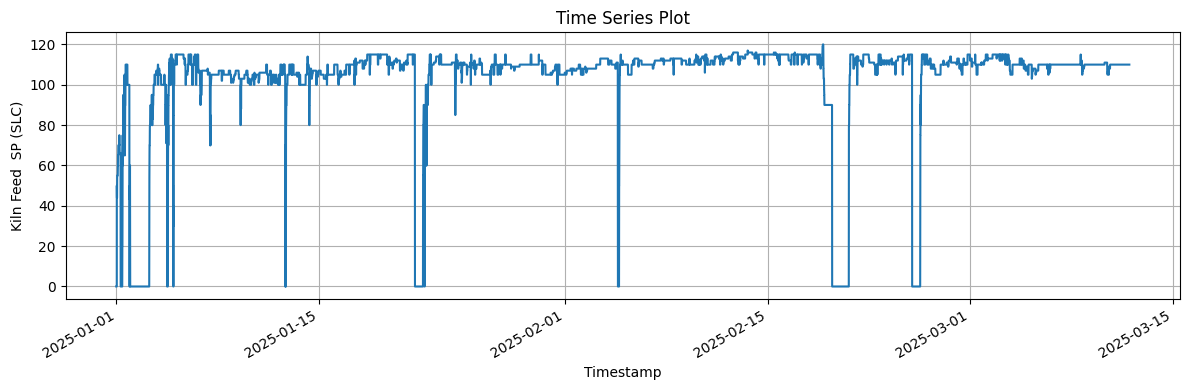

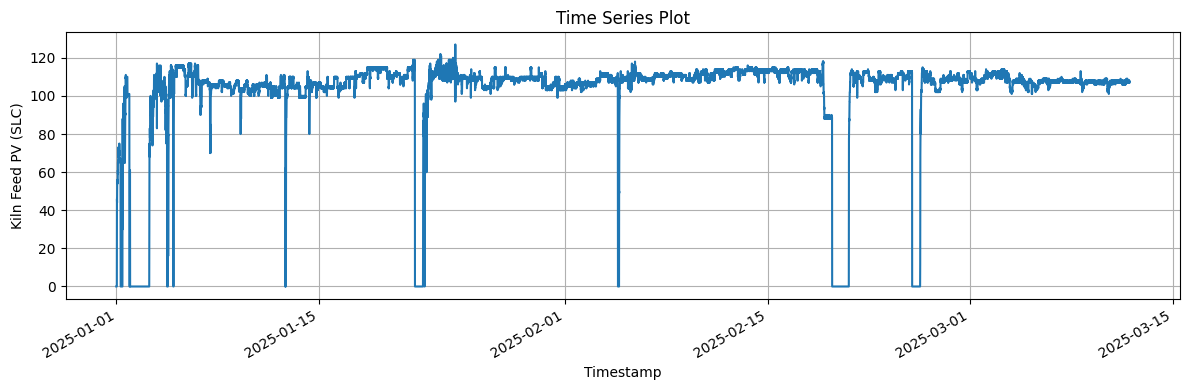

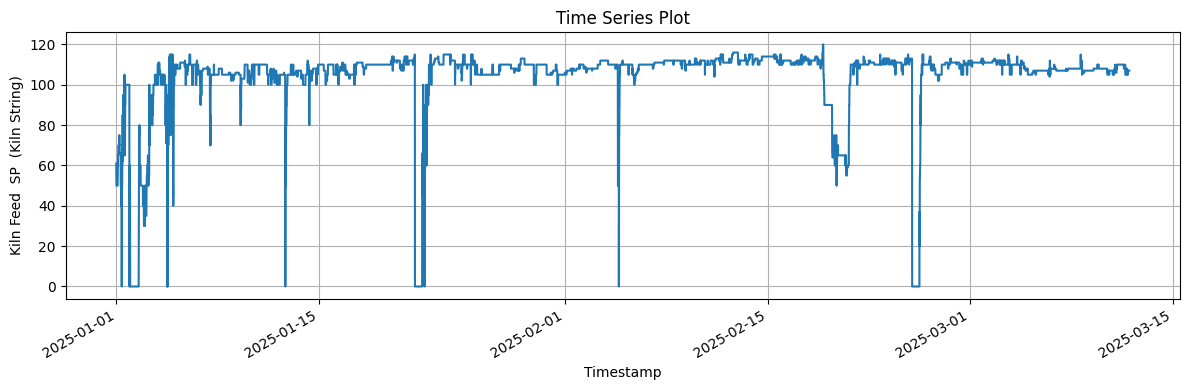

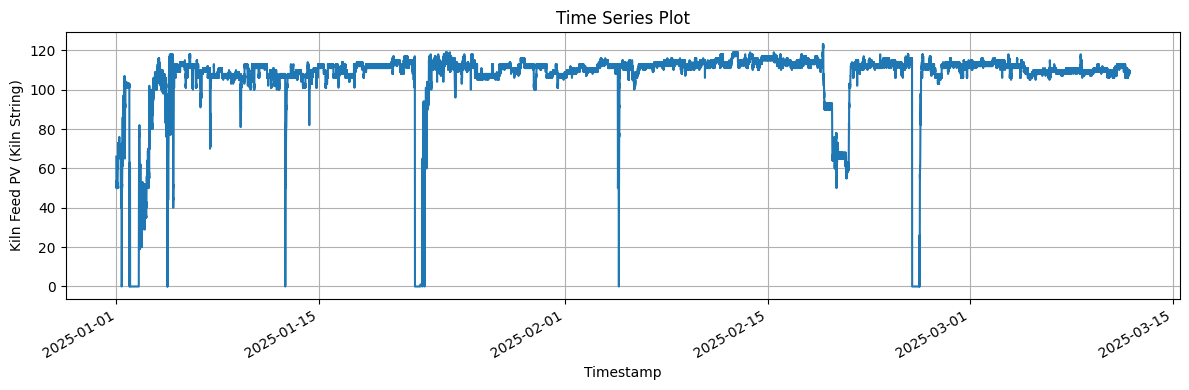

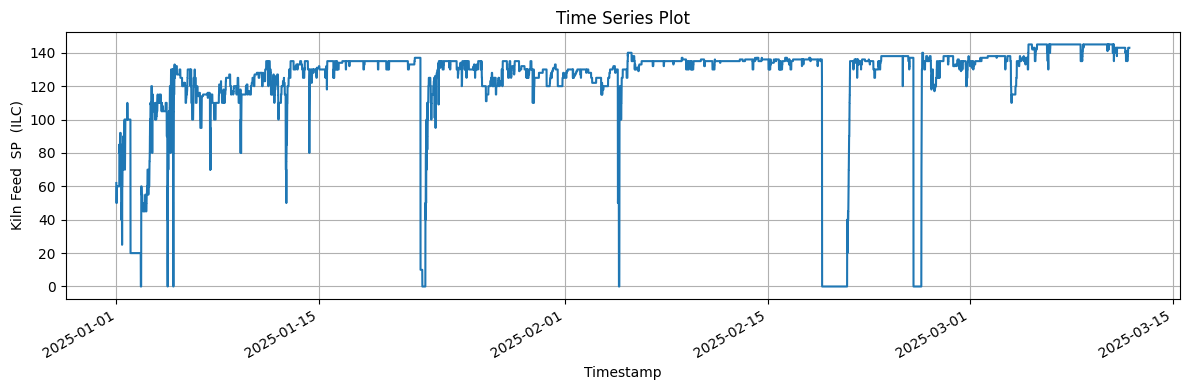

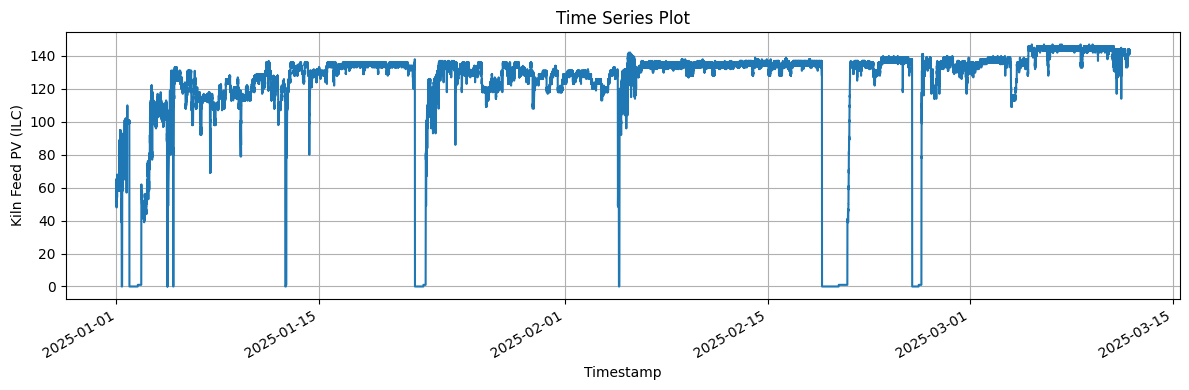

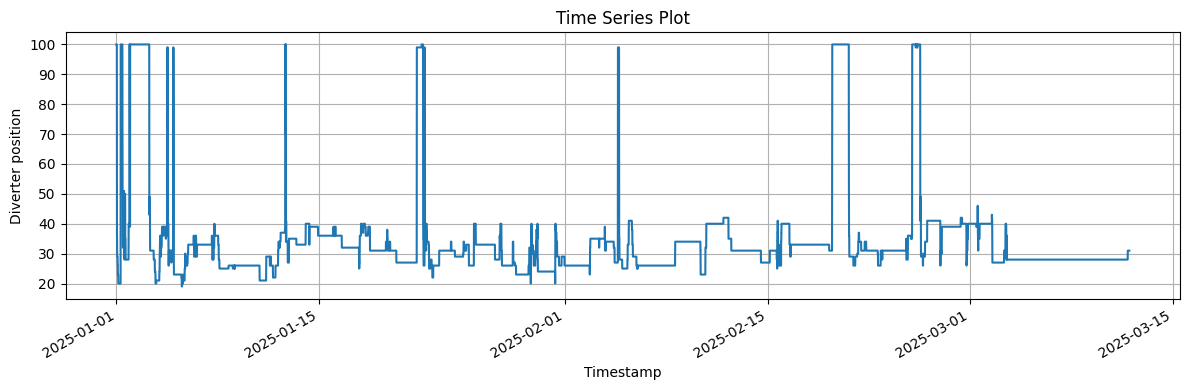

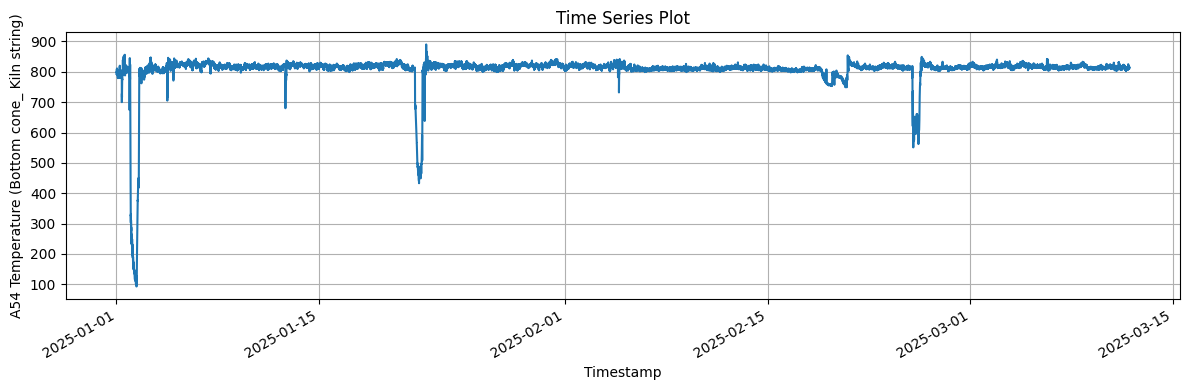

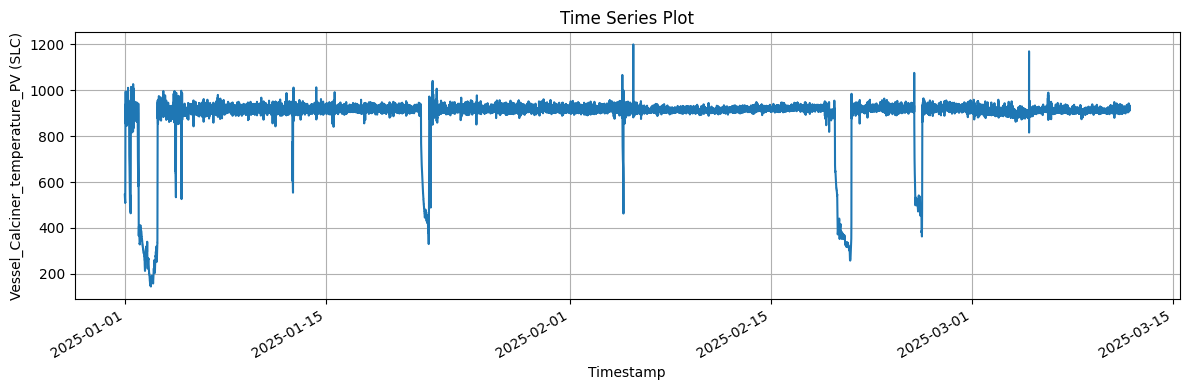

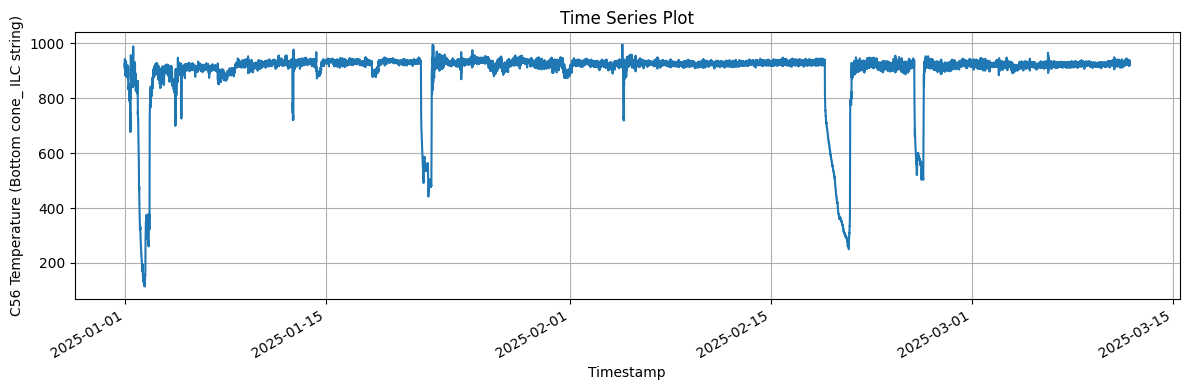

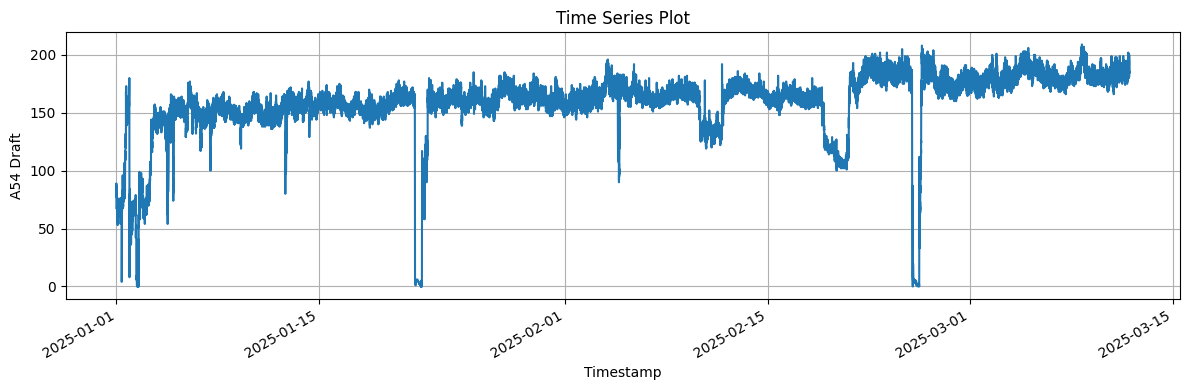

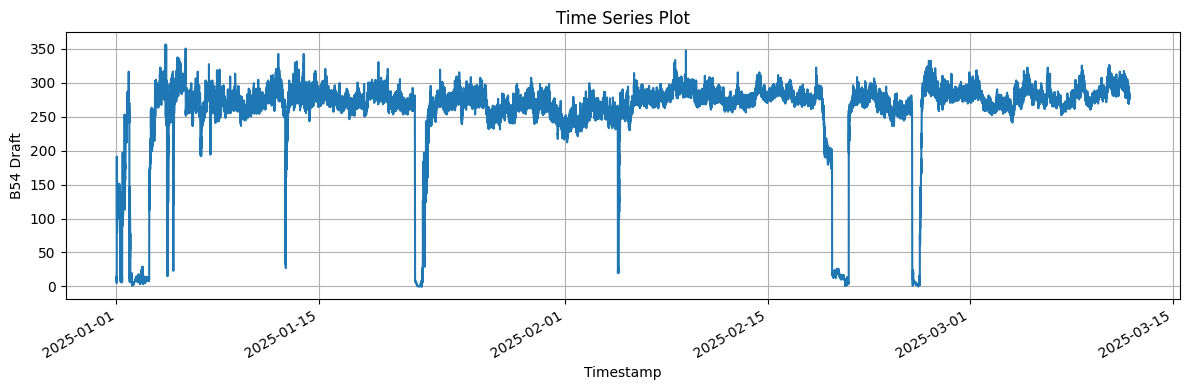

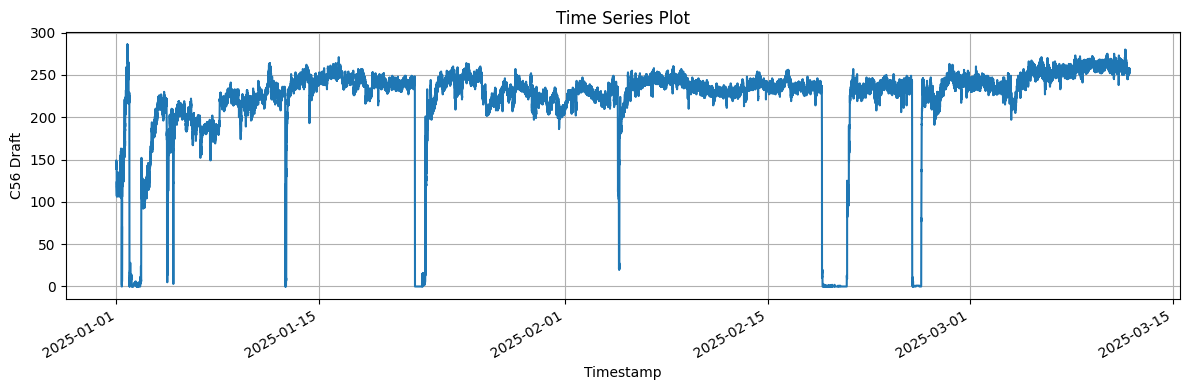

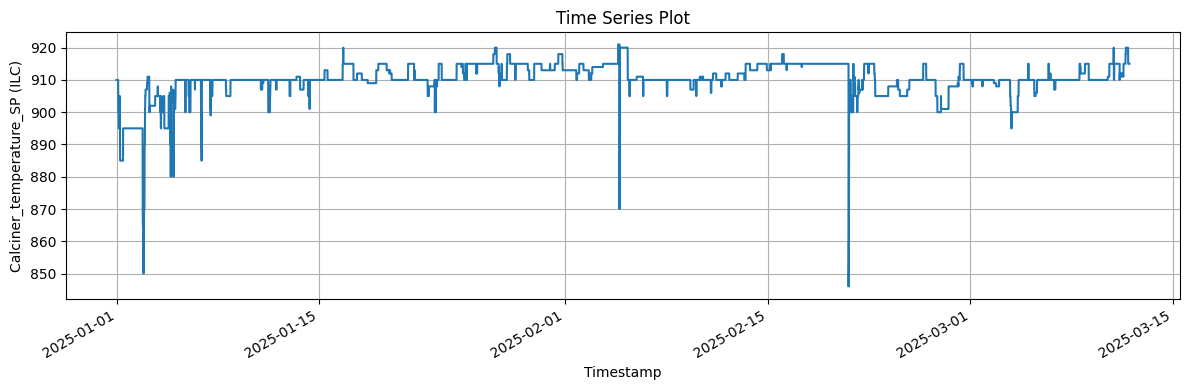

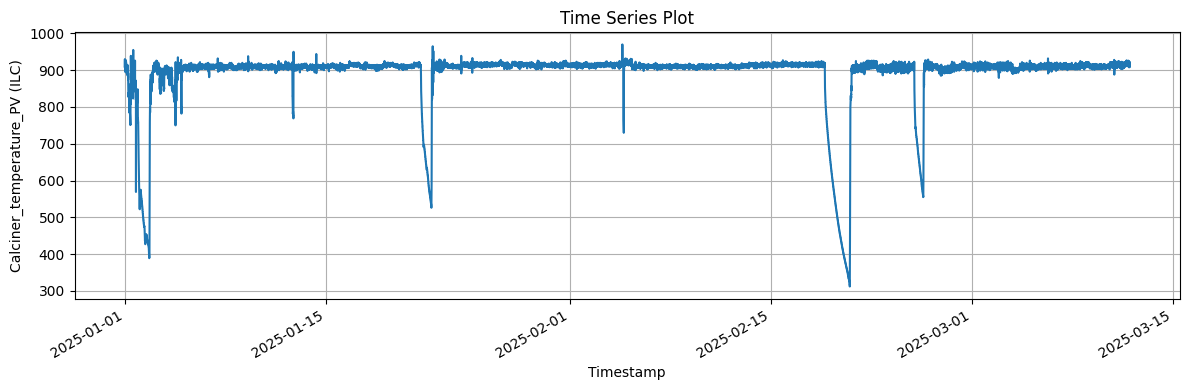

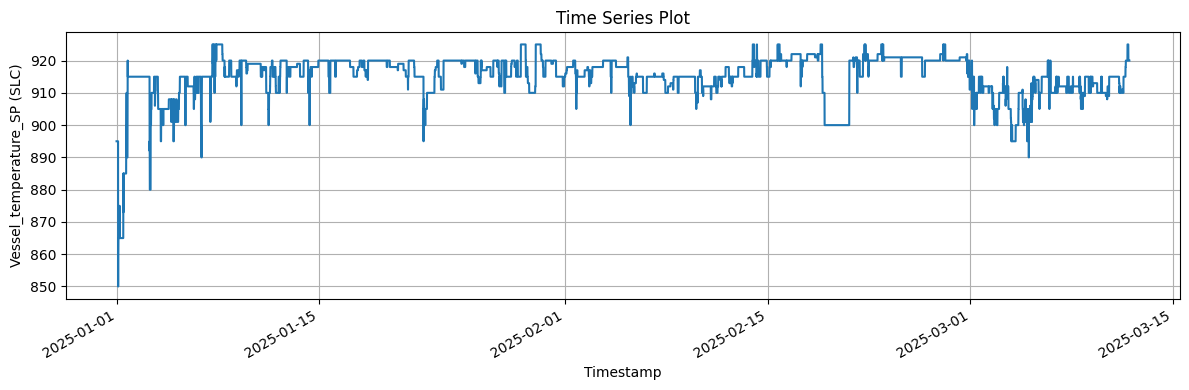

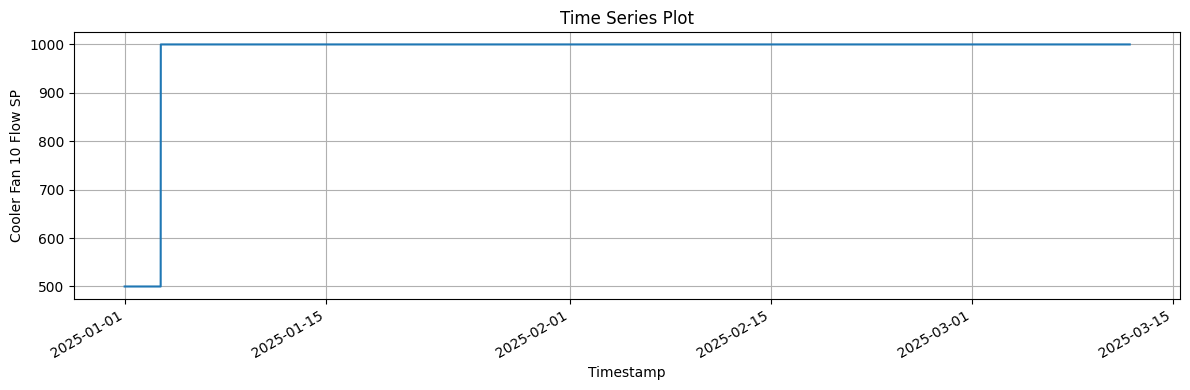

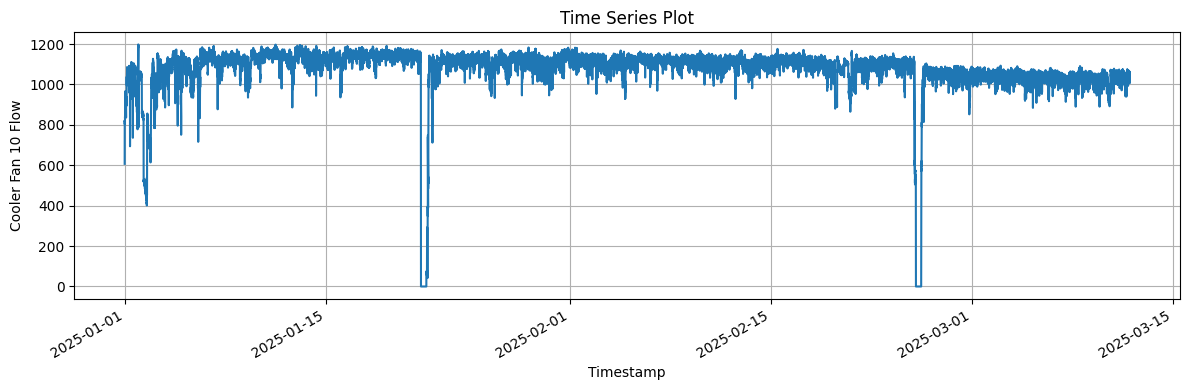

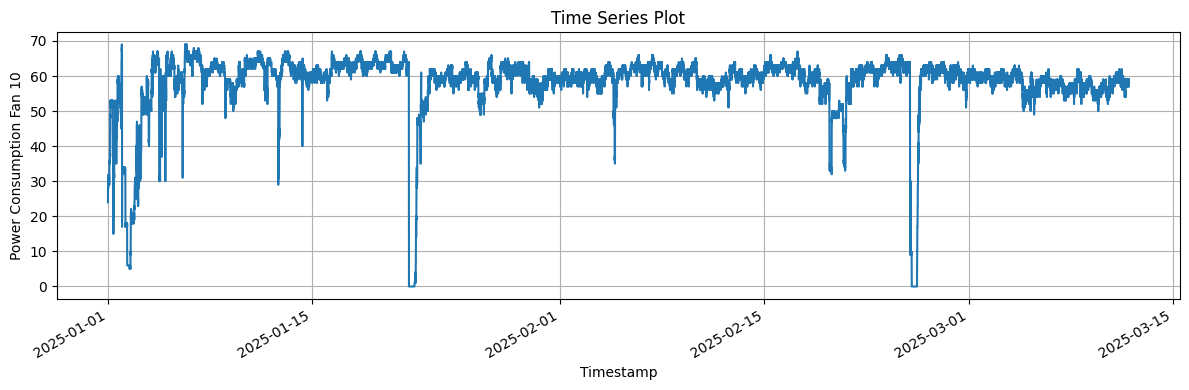

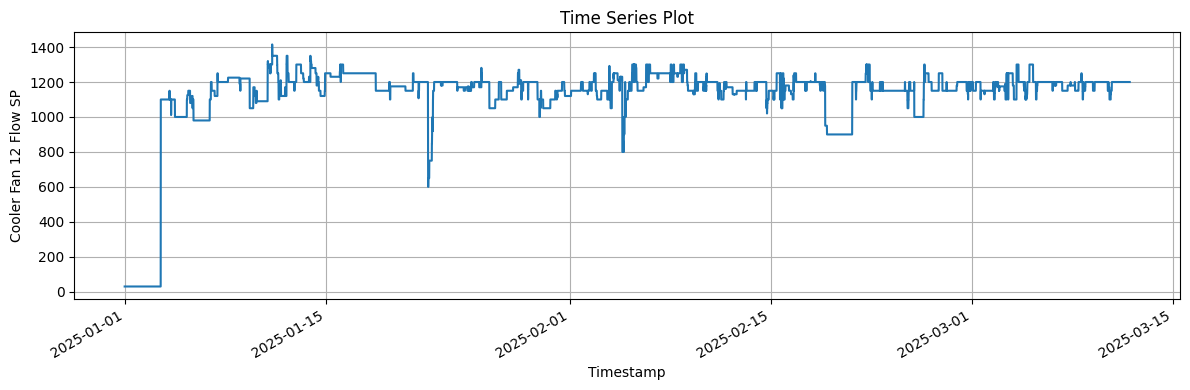

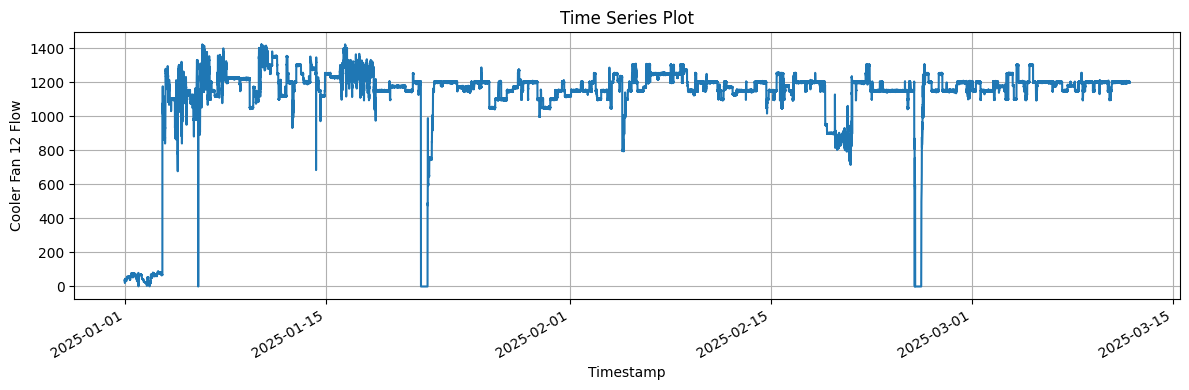

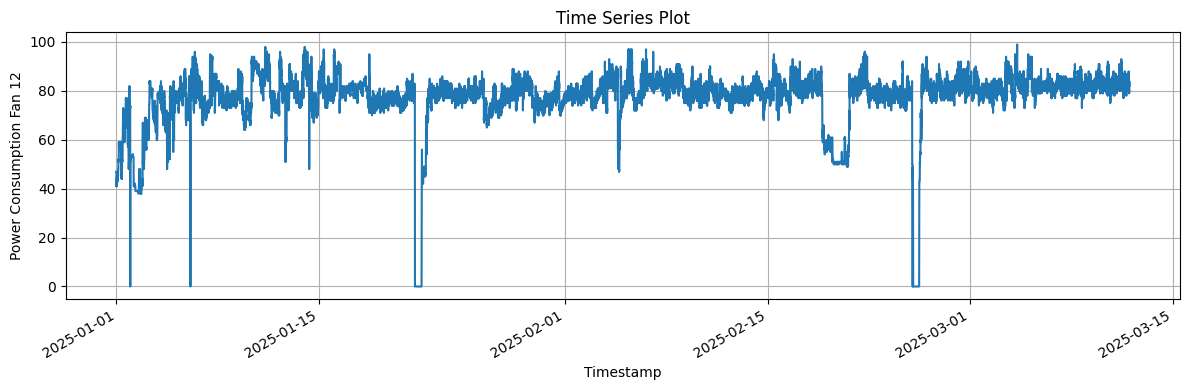

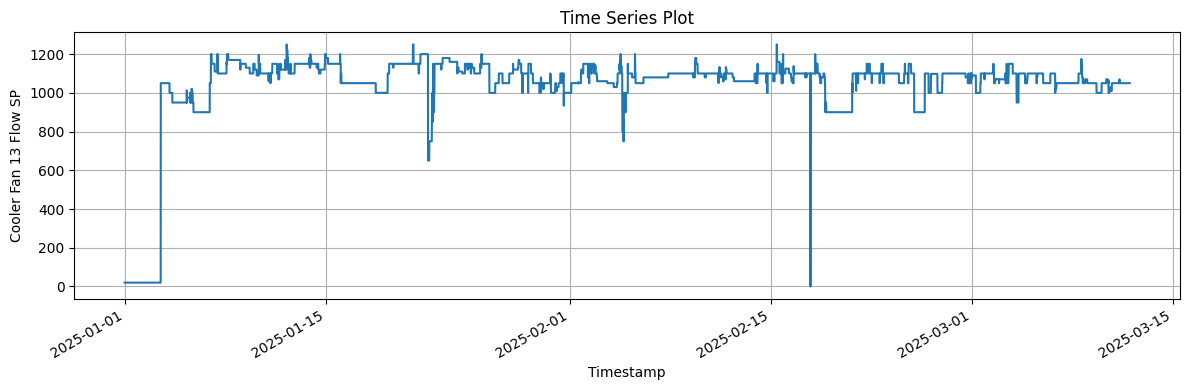

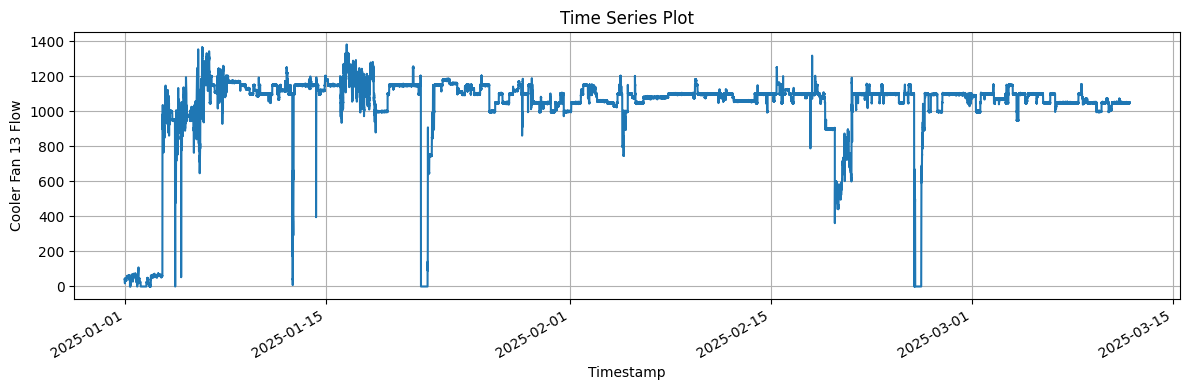

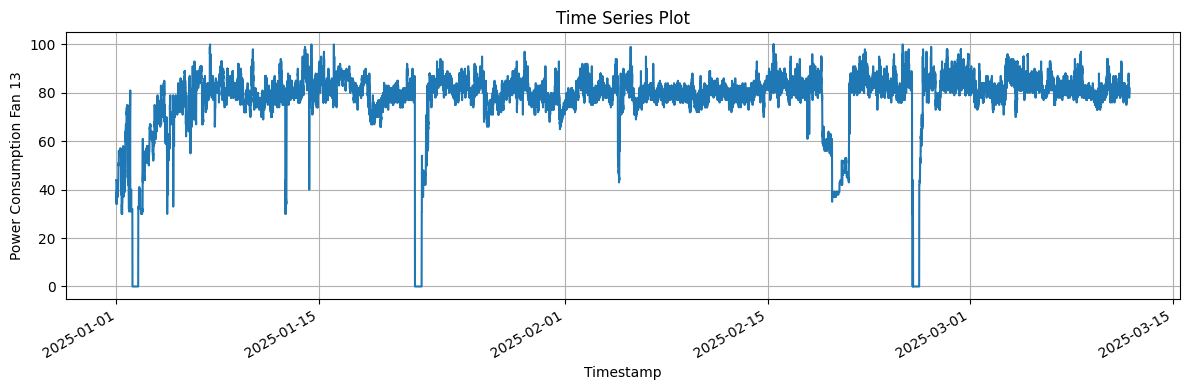

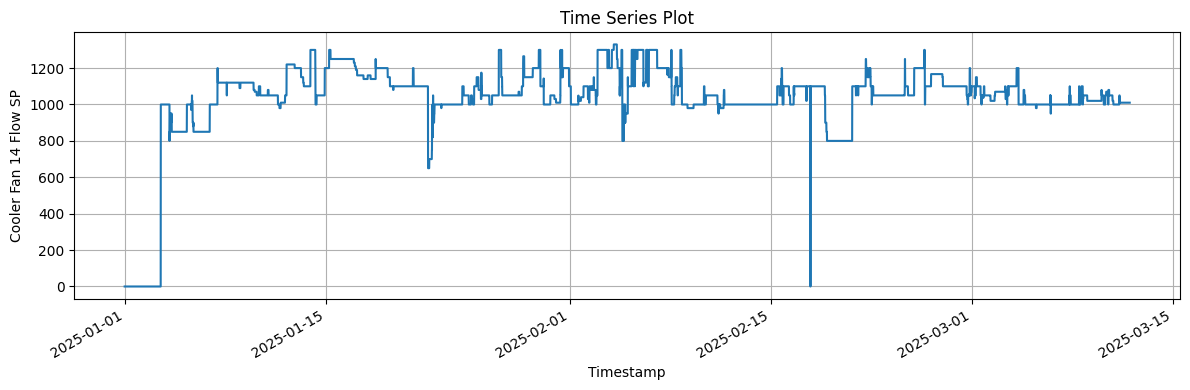

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001A697FCC650>>
Traceback (most recent call last):
  File "c:\Users\dixshant.shreemal-st\VSCode\UTCL Cement Data\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


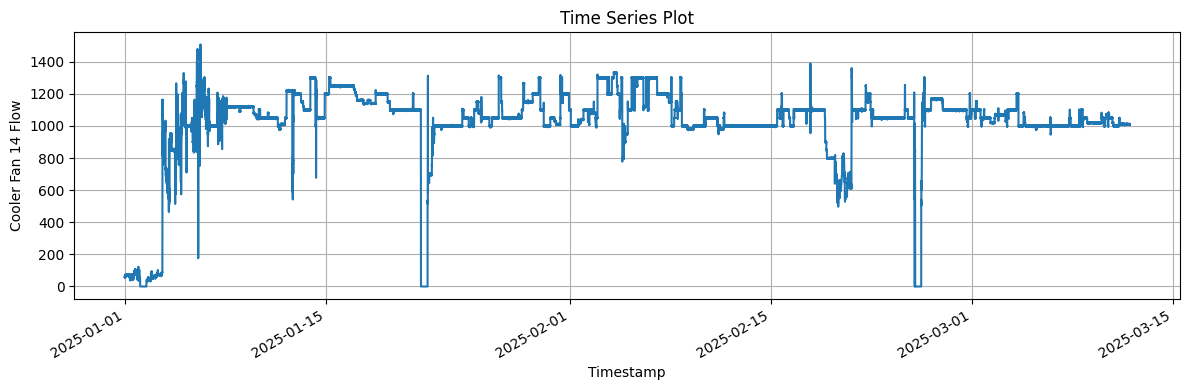

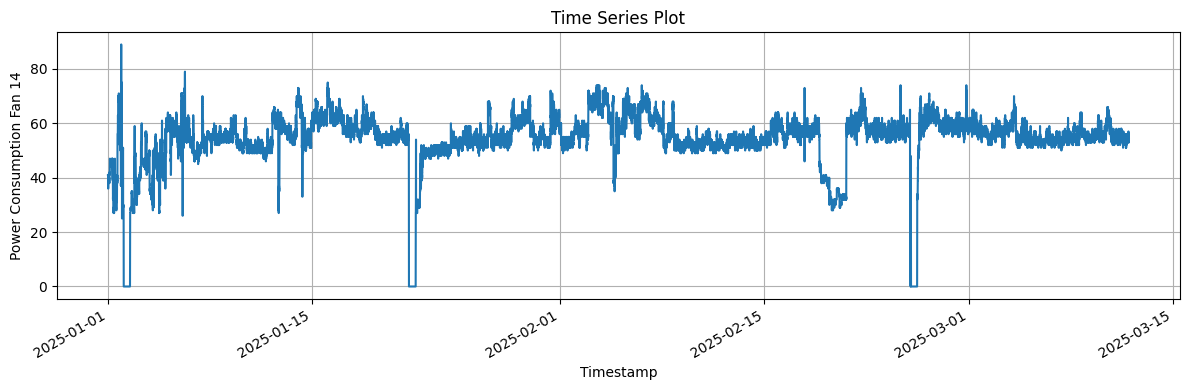

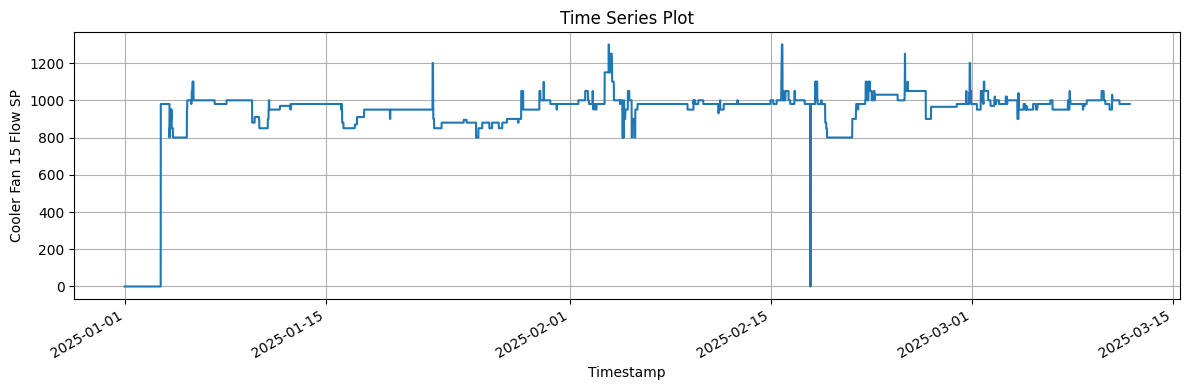

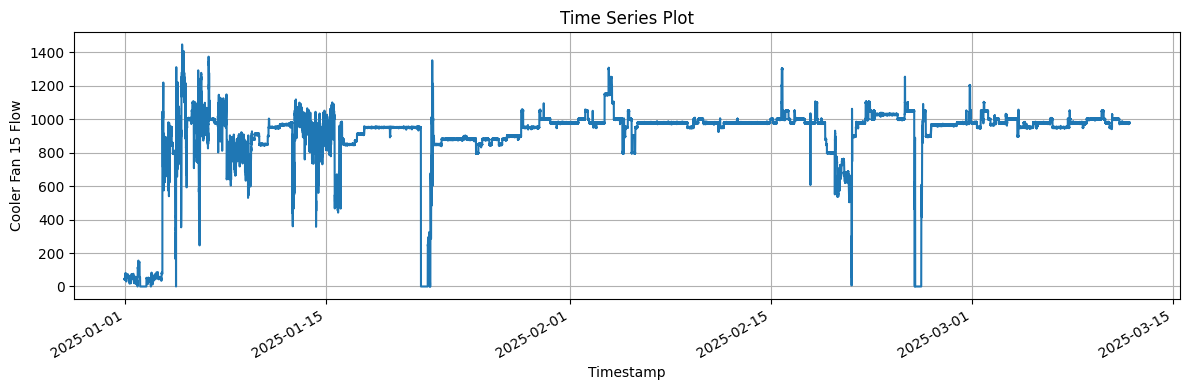

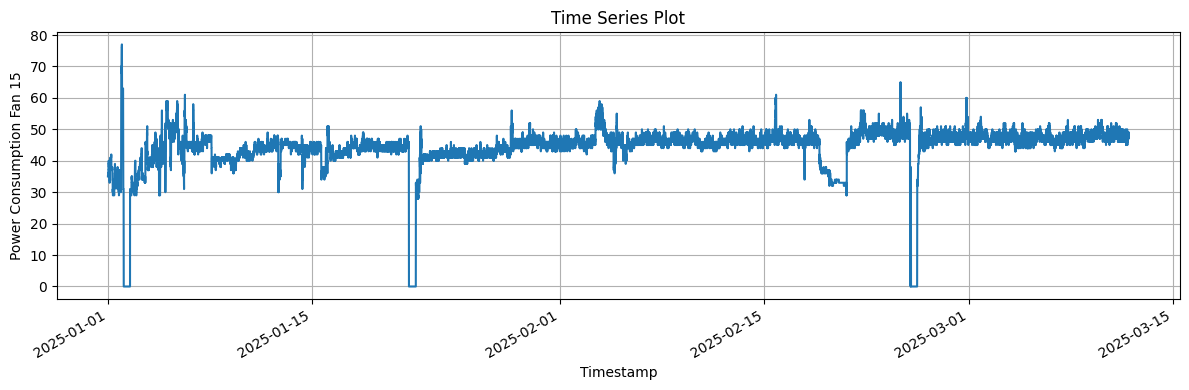

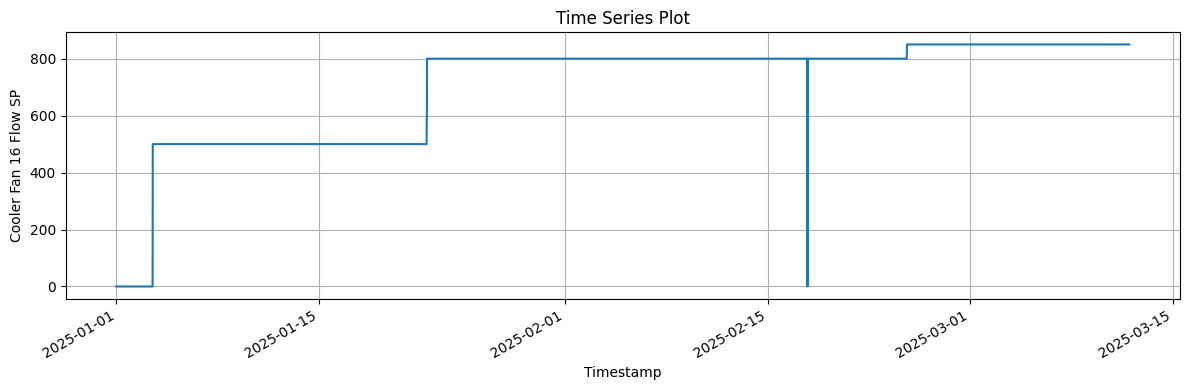

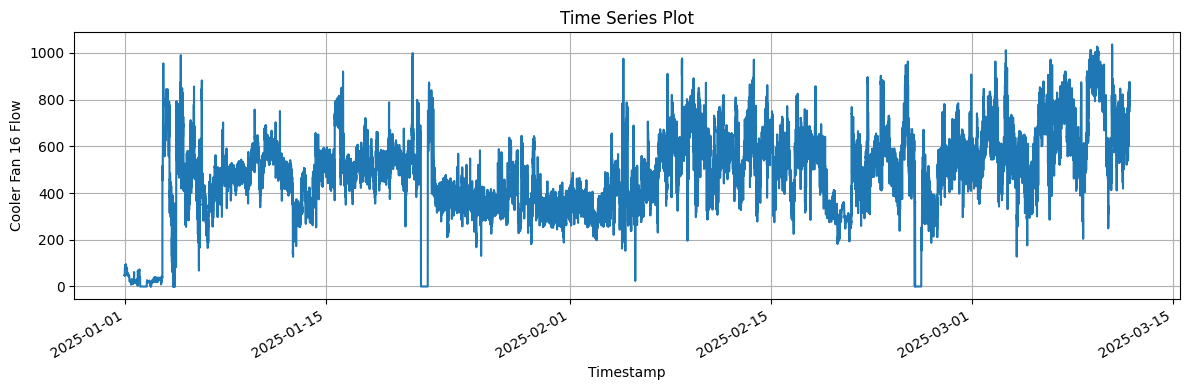

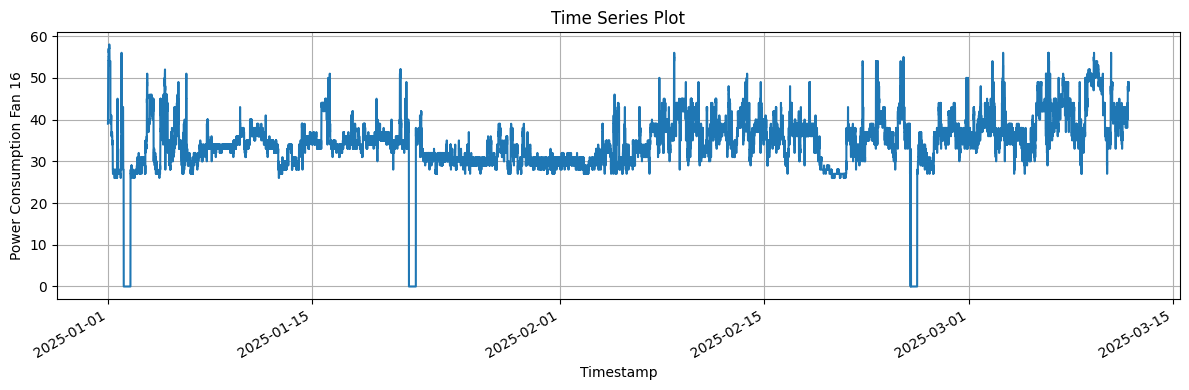

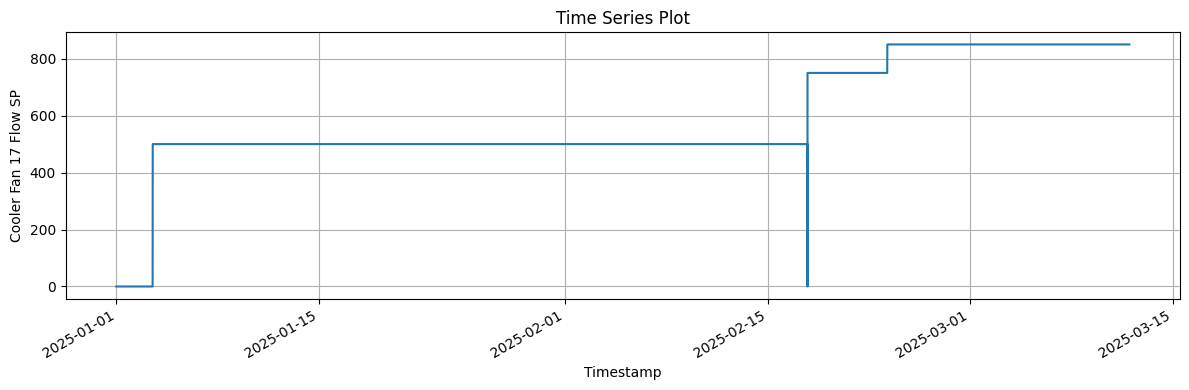

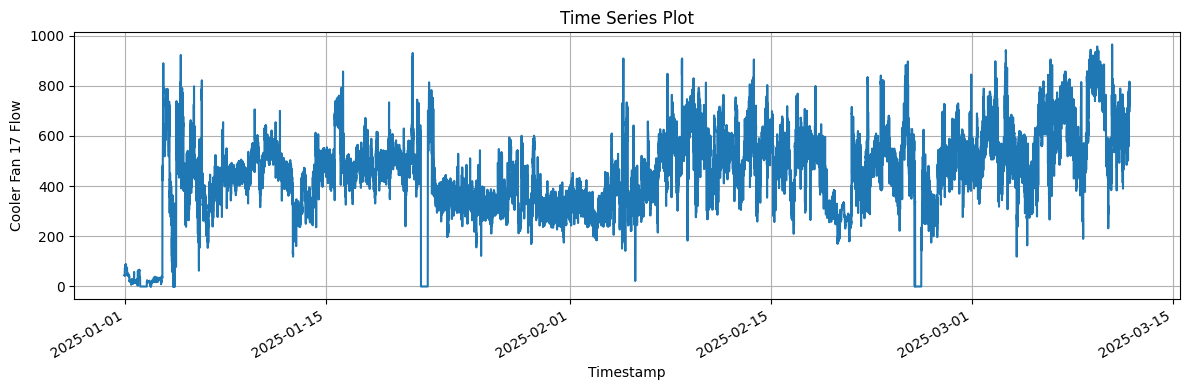

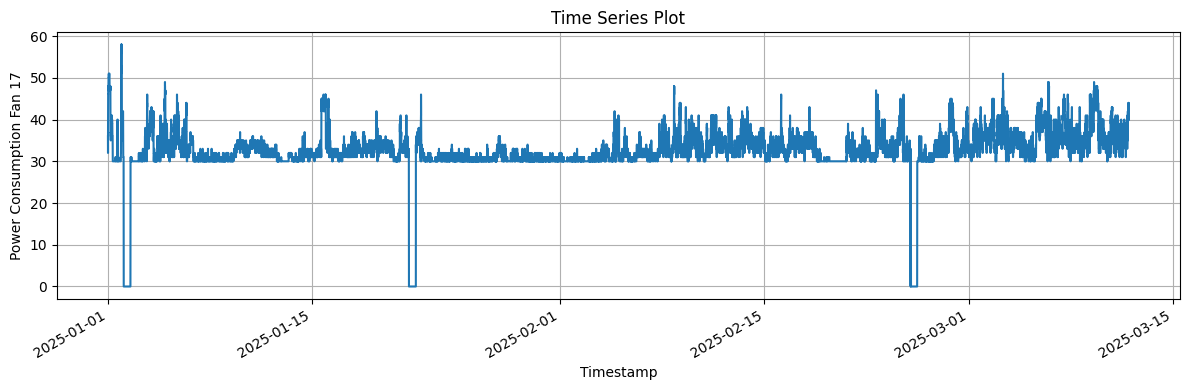

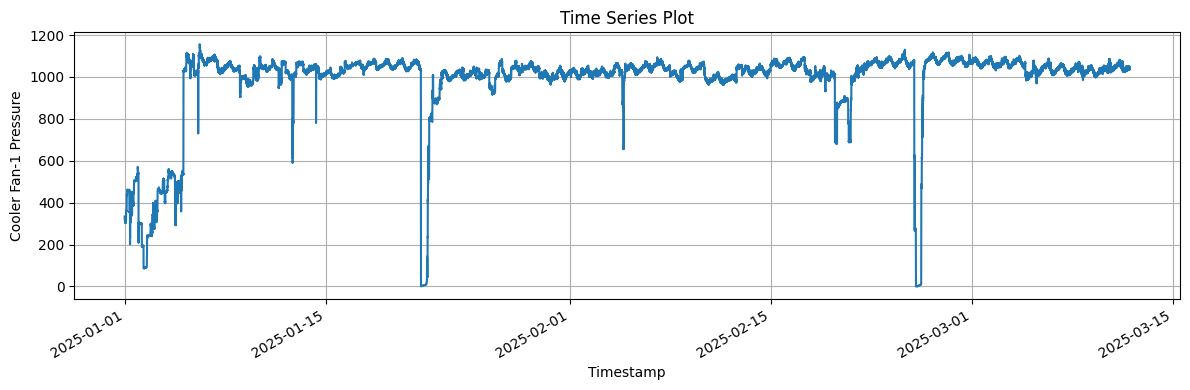

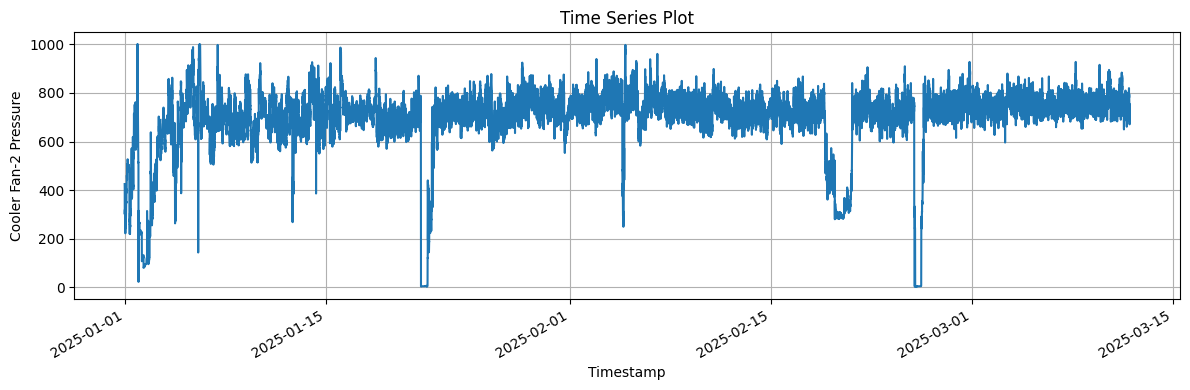

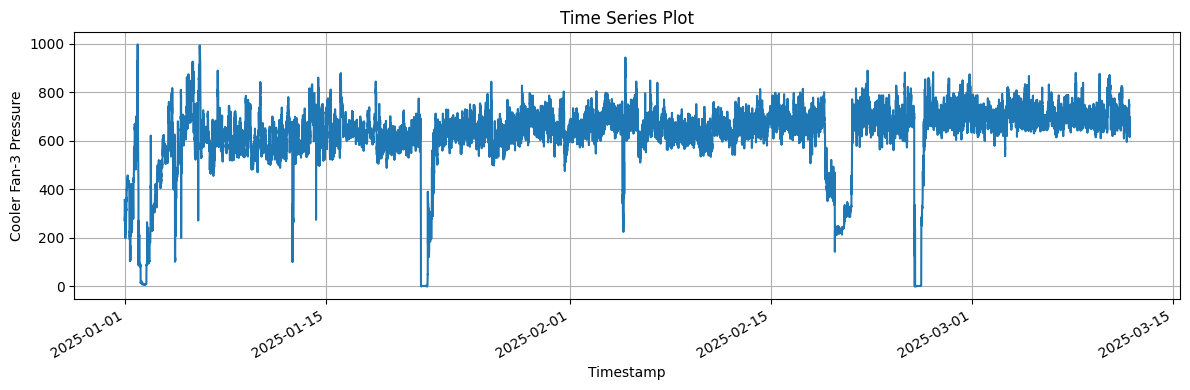

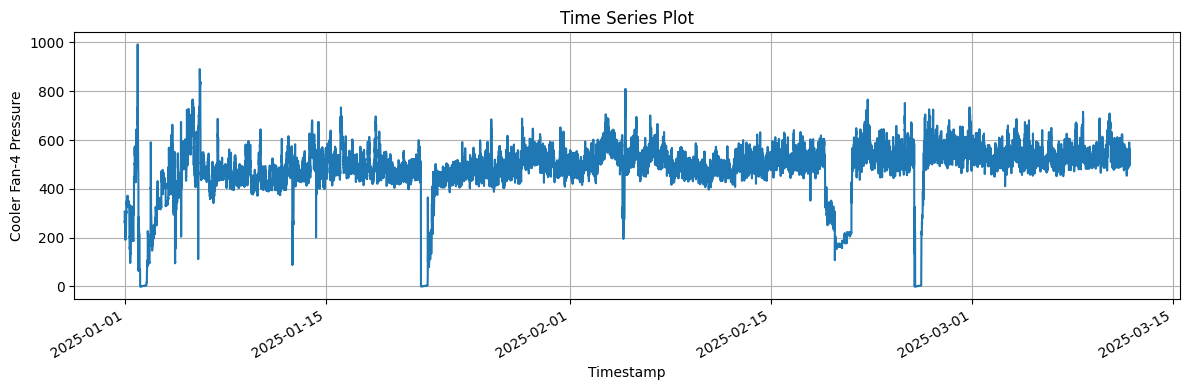

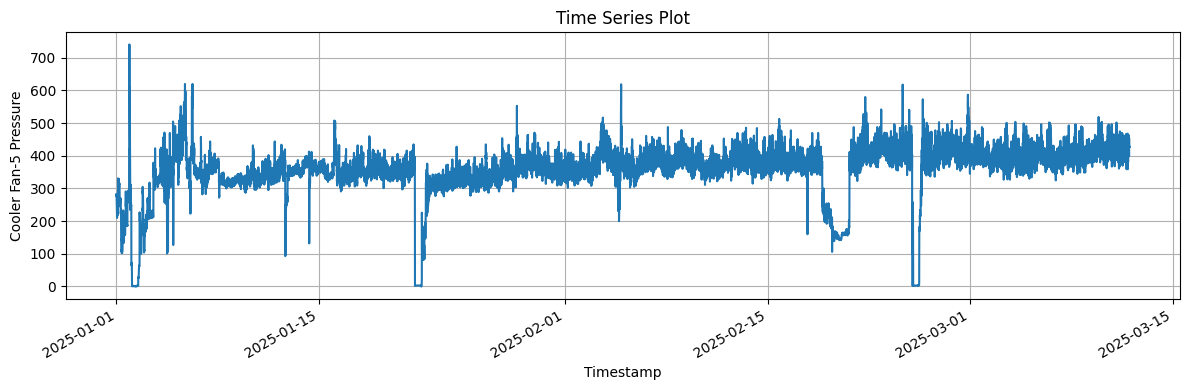

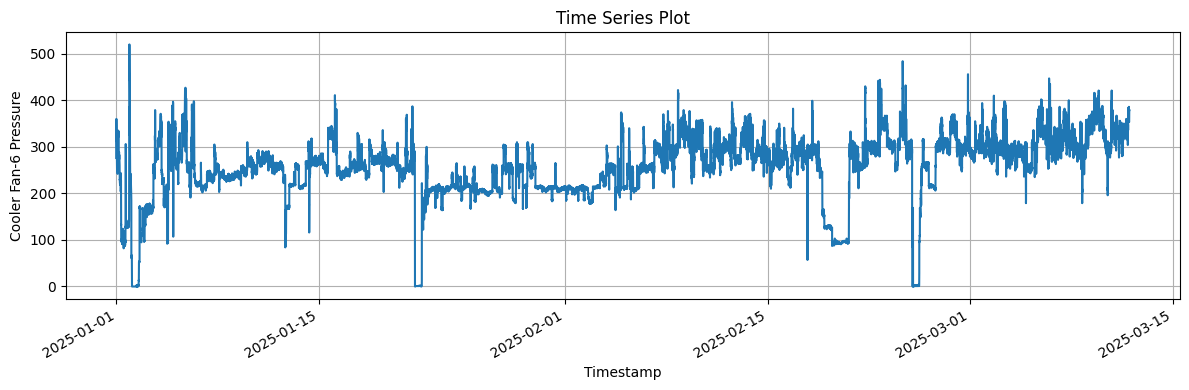

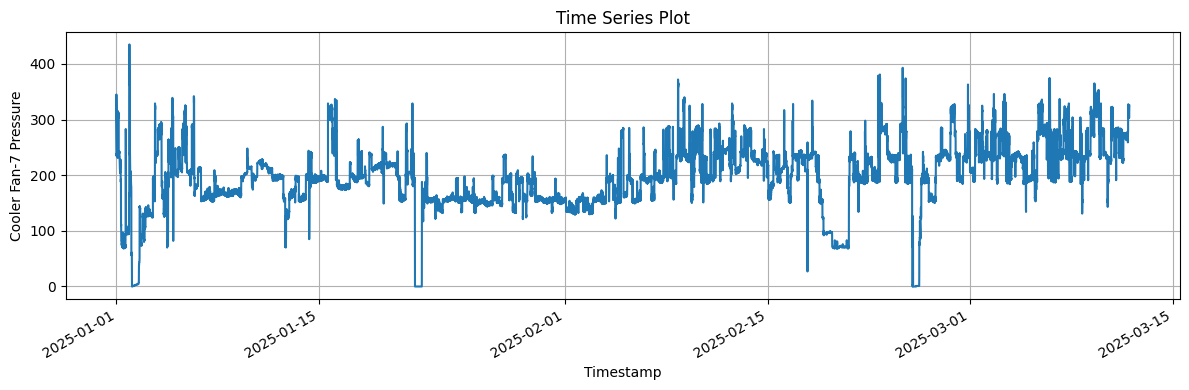

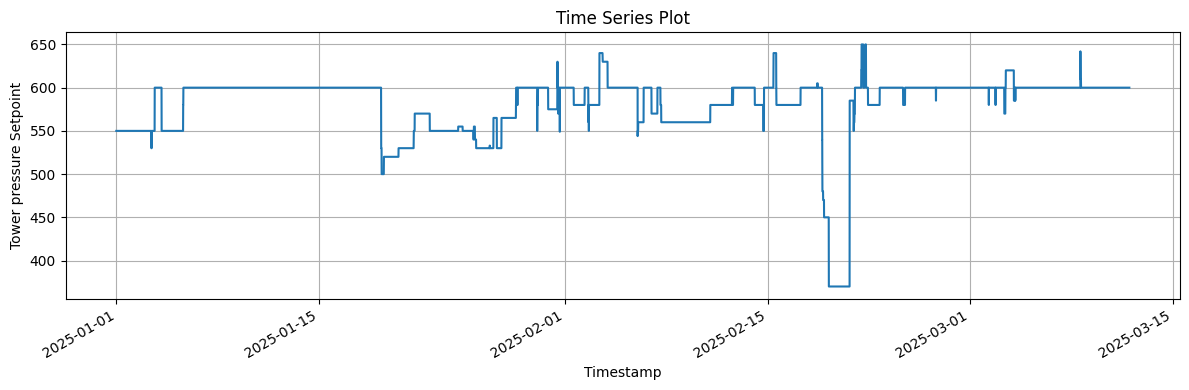

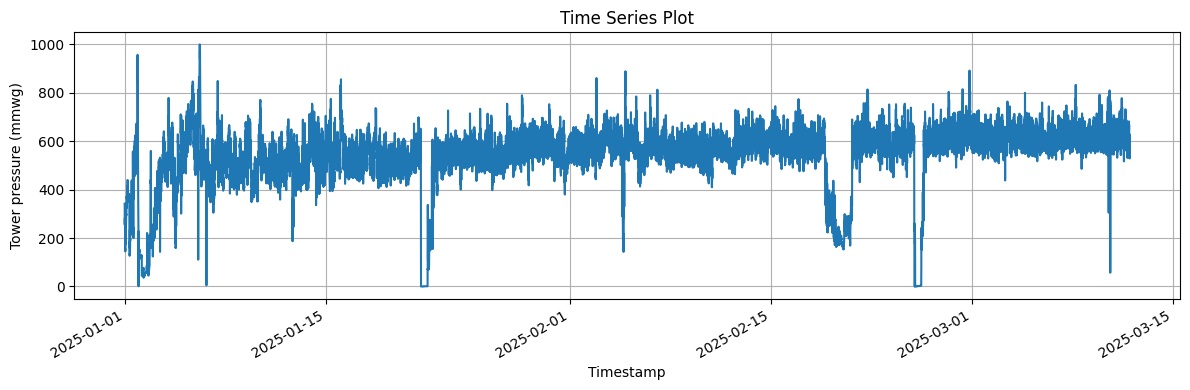

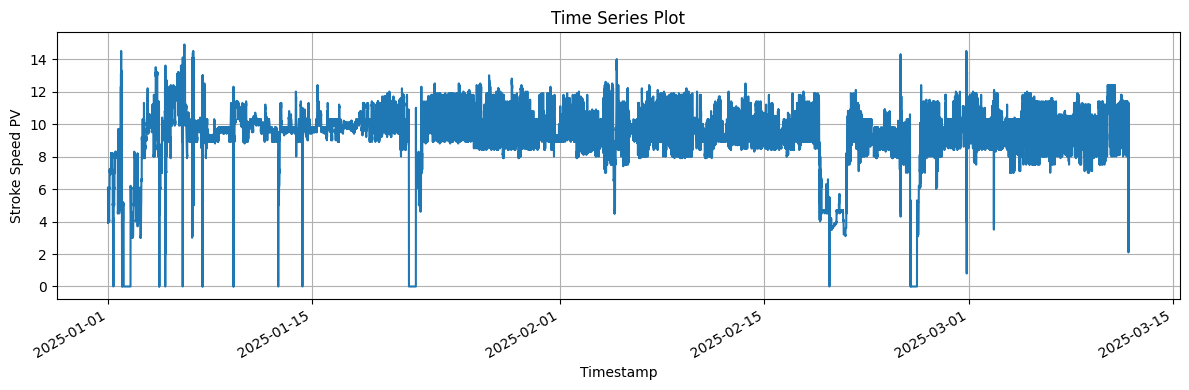

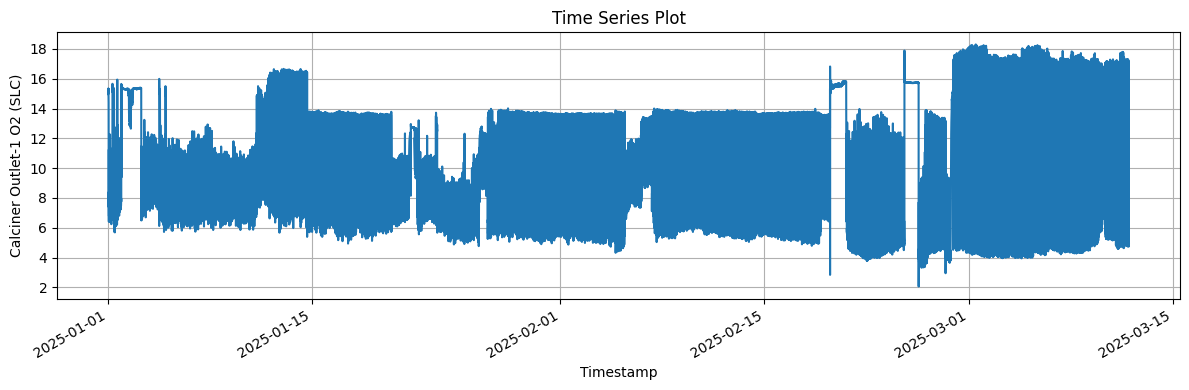

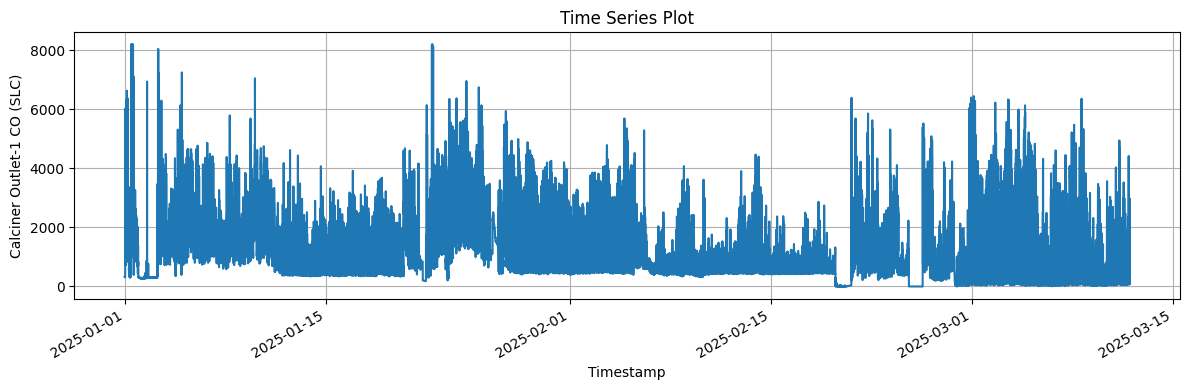

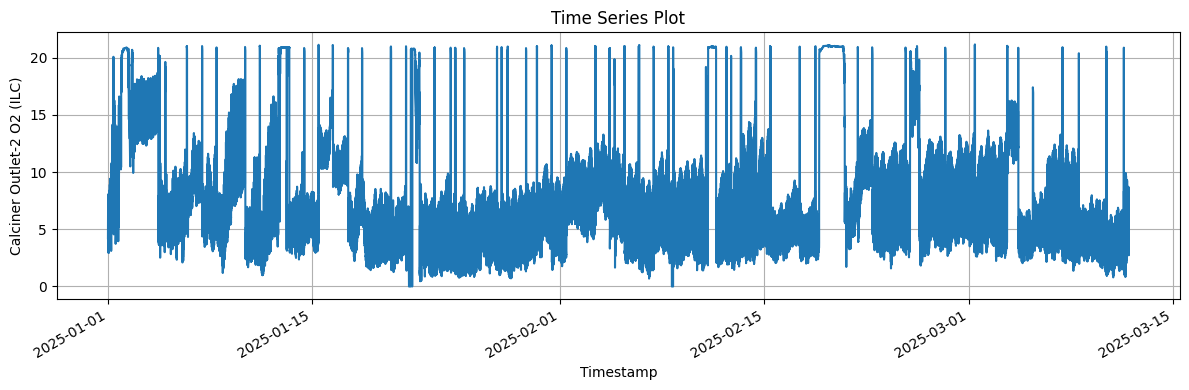

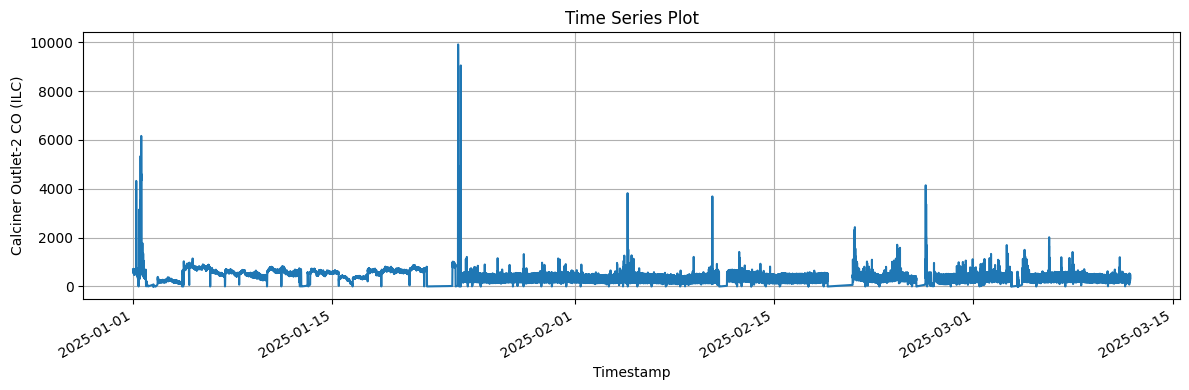

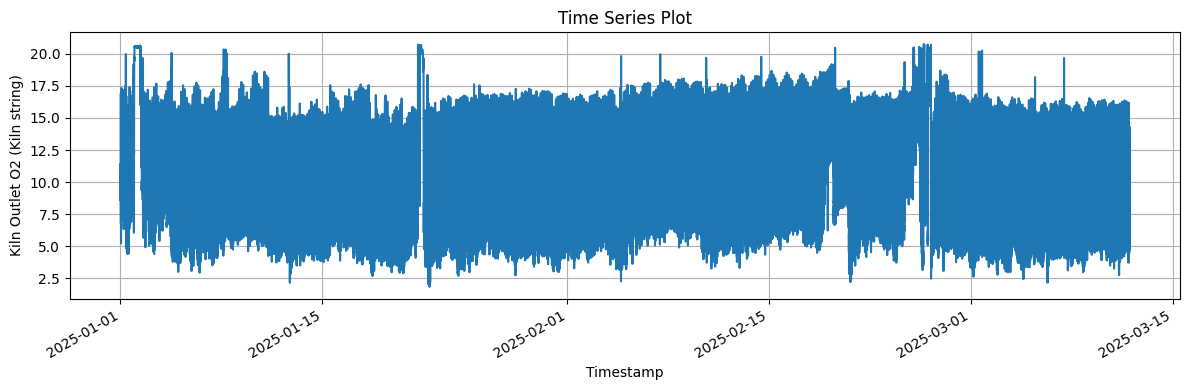

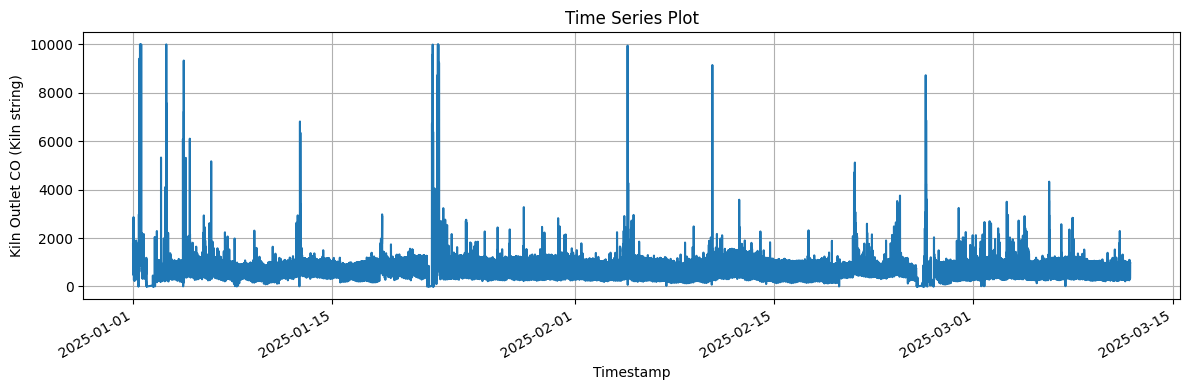

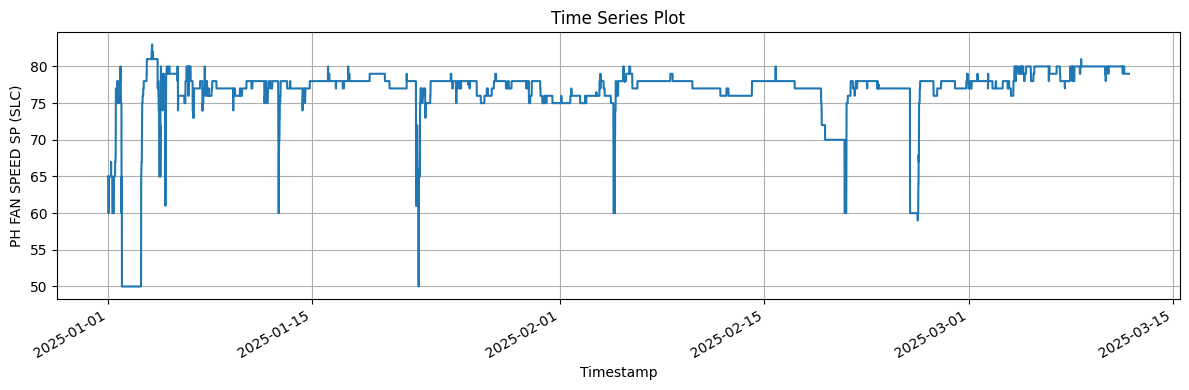

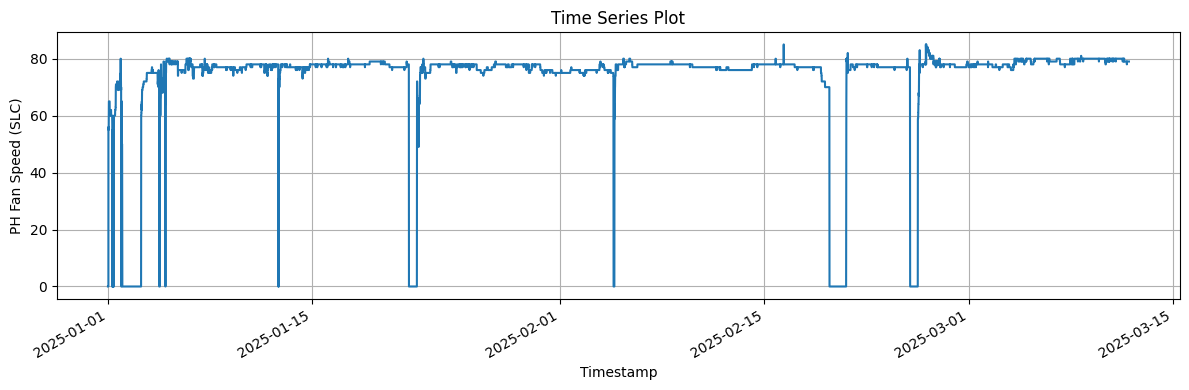

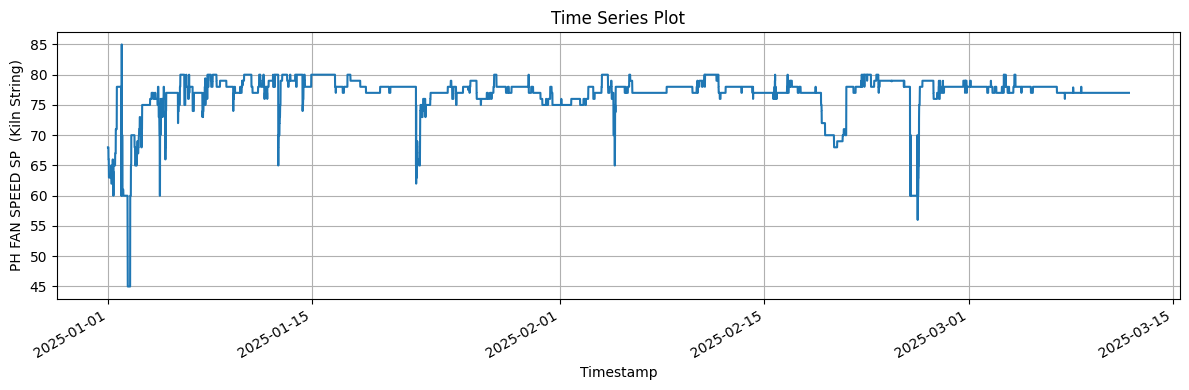

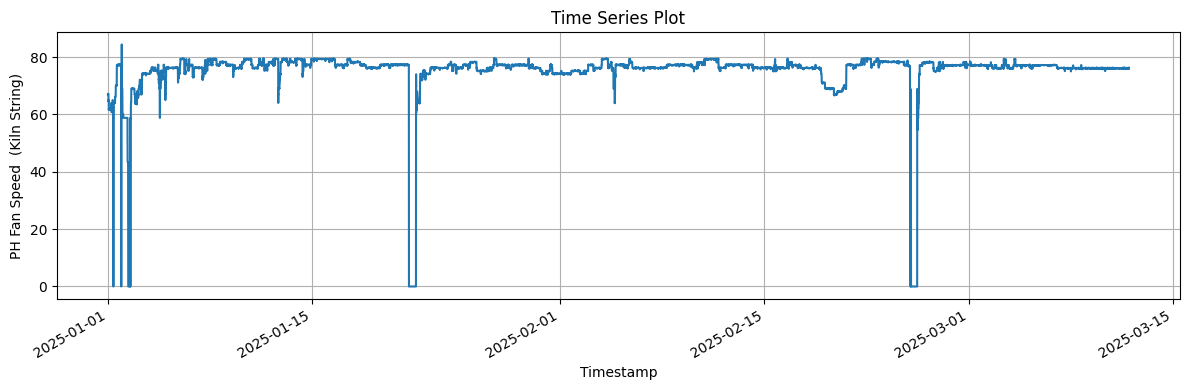

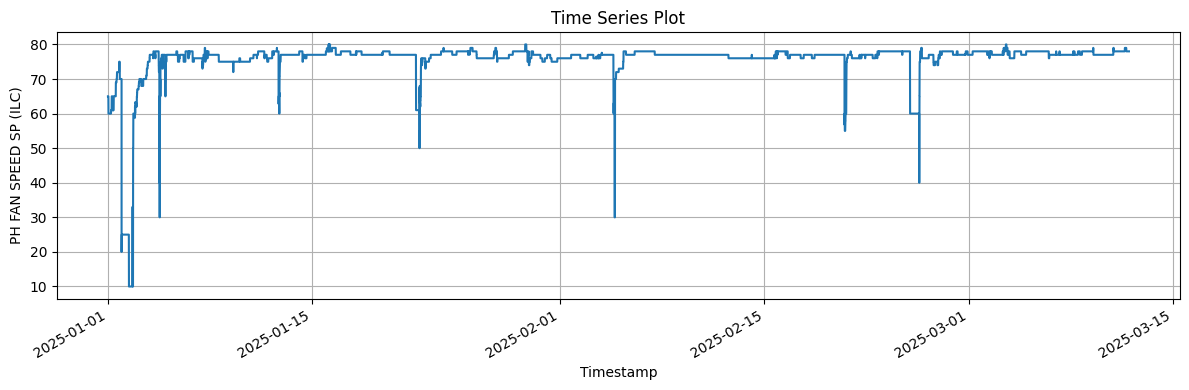

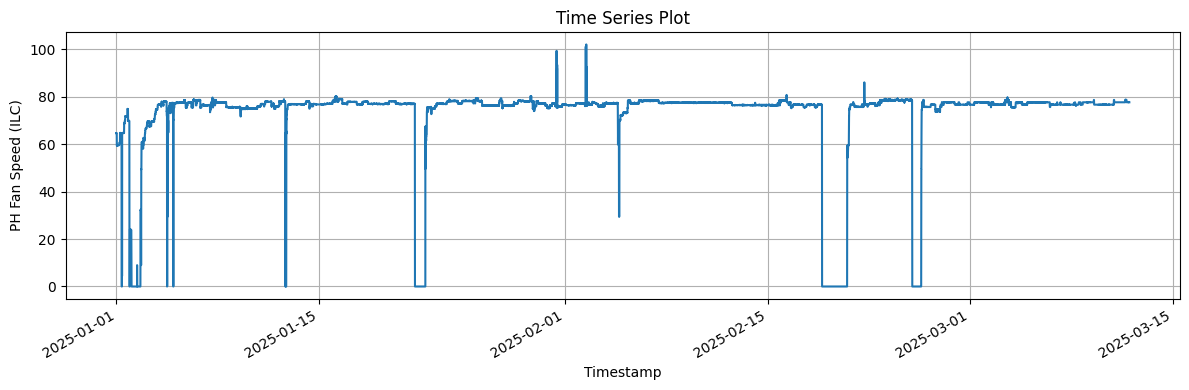

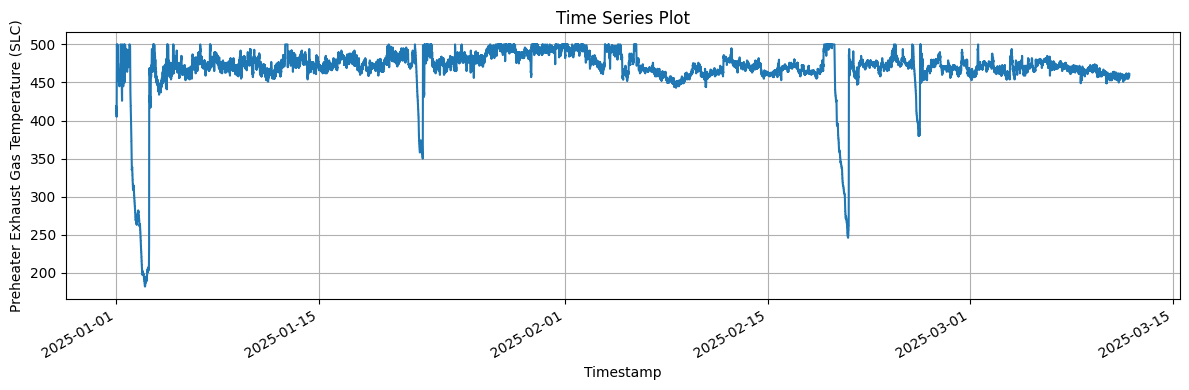

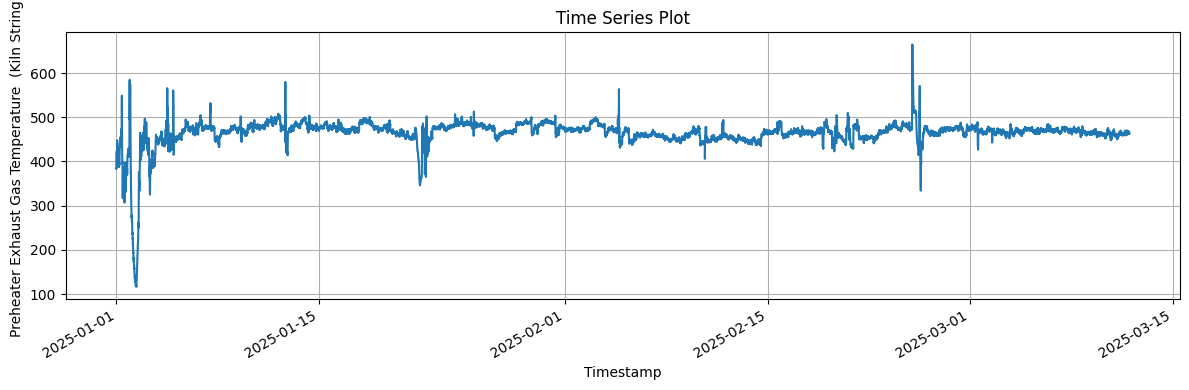

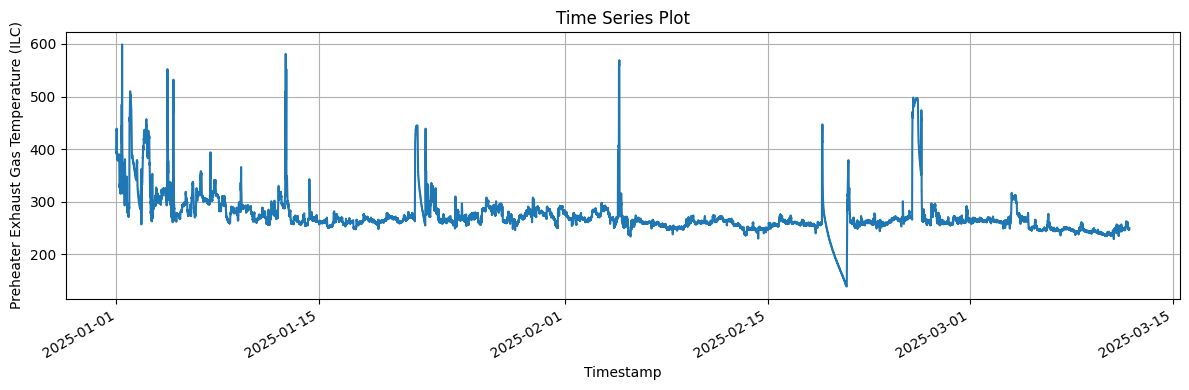

In [8]:
for col in df:
    df[col].plot(figsize=(12, 4))
    plt.title("Time Series Plot")
    plt.ylabel(f"{col}")
    plt.xlabel("Timestamp")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Data Cleaning

Remove tags with 'sp' in their names

In [9]:
df = df[[col for col in df.columns if all(x not in col for x in [' SP ', '_SP ', 'Setpoint', ' SP'])]]
df

Specific Air consumption  Clinker temperature  \
time_stamp                                                           
2025-01-01 00:01:00                     13.26                 83.0   
2025-01-01 00:02:00                     15.55                 84.0   
2025-01-01 00:03:00                     17.96                 84.0   
2025-01-01 00:04:00                     19.19                 84.0   
2025-01-01 00:05:00                     19.30                 83.0   
...                                       ...                  ...   
2025-03-11 23:55:00                      2.03                147.0   
2025-03-11 23:56:00                      2.03                147.0   
2025-03-11 23:57:00                      2.03                147.0   
2025-03-11 23:58:00                      2.02                147.0   
2025-03-11 23:59:00                      2.02                147.0   

                     Secondary Air Temperature  Kiln Hood Draft temperature  \
time_stamp                                                                    
2025-01-01 00:01:00                      464.0                        -3.23   
2025-01-01 00:02:00                      458.0                        -3.08   
2025-01-01 00:03:00                      453.0                        -2.52   
2025-01-01 00:04:00                      448.0                        -2.12   
2025-01-01 00:05:00                      443.0                        -2.05   
...                                        ...                          ...   
2025-03-11 23:55:00                      928.0                        -3.36   
2025-03-11 23:56:00                      924.0                        -3.63   
2025-03-11 23:57:00                      919.0                        -3.67   
2025-03-11 23:58:00                      915.0                        -4.22   
2025-03-11 23:59:00                      911.0                        -3.91   

                     TA Duct Draft  TA Duct Temperature  \
time_stamp                                                
2025-01-01 00:01:00            0.0                727.0   
2025-01-01 00:02:00            0.0                735.0   
2025-01-01 00:03:00            0.0                743.0   
2025-01-01 00:04:00            0.0                751.0   
2025-01-01 00:05:00            0.0                759.0   
...                            ...                  ...   
2025-03-11 23:55:00            0.0               1085.0   
2025-03-11 23:56:00            0.0               1087.0   
2025-03-11 23:57:00            0.0               1088.0   
2025-03-11 23:58:00            0.0               1090.0   
2025-03-11 23:59:00            0.0               1091.0   

                     Cooler vent Fan Speed (Cooler outlet Fan_ ESP Inlet Fan) PV  \
time_stamp                                                                         
2025-01-01 00:01:00                                               70.0             
2025-01-01 00:02:00                                               70.0             
2025-01-01 00:03:00                                               70.0             
2025-01-01 00:04:00                                               70.0             
2025-01-01 00:05:00                                               70.0             
...                                                                ...             
2025-03-11 23:55:00                                               94.0             
2025-03-11 23:56:00                                               94.0             
2025-03-11 23:57:00                                               94.0             
2025-03-11 23:58:00                                               94.0             
2025-03-11 23:59:00                                               94.0             

                     Coal Feed Rate (Calciner String)  Kiln Coal Feed Rate  \
time_stamp                                                                   
2025-01-01 00:01:00                              9.14            

Remove rows where sum of kiln feed <250 (plant is off)

In [10]:
df = df[df['Kiln Feed PV (SLC)'] + df['Kiln Feed PV (Kiln String)'] + df['Kiln Feed PV (ILC)'] > 250]
df

Specific Air consumption  Clinker temperature  \
time_stamp                                                           
2025-01-01 11:23:00                     11.08                 74.0   
2025-01-01 11:24:00                     10.85                 75.0   
2025-01-01 11:25:00                     10.73                 75.0   
2025-01-01 11:26:00                     10.91                 74.0   
2025-01-01 11:27:00                     10.90                 76.0   
...                                       ...                  ...   
2025-03-11 23:55:00                      2.03                147.0   
2025-03-11 23:56:00                      2.03                147.0   
2025-03-11 23:57:00                      2.03                147.0   
2025-03-11 23:58:00                      2.02                147.0   
2025-03-11 23:59:00                      2.02                147.0   

                     Secondary Air Temperature  Kiln Hood Draft temperature  \
time_stamp                                                                    
2025-01-01 11:23:00                      585.0                        -0.41   
2025-01-01 11:24:00                      593.0                         0.31   
2025-01-01 11:25:00                      604.0                         1.47   
2025-01-01 11:26:00                      615.0                         1.63   
2025-01-01 11:27:00                      627.0                         1.58   
...                                        ...                          ...   
2025-03-11 23:55:00                      928.0                        -3.36   
2025-03-11 23:56:00                      924.0                        -3.63   
2025-03-11 23:57:00                      919.0                        -3.67   
2025-03-11 23:58:00                      915.0                        -4.22   
2025-03-11 23:59:00                      911.0                        -3.91   

                     TA Duct Draft  TA Duct Temperature  \
time_stamp                                                
2025-01-01 11:23:00            1.0                515.0   
2025-01-01 11:24:00            1.0                531.0   
2025-01-01 11:25:00            1.0                547.0   
2025-01-01 11:26:00            1.0                564.0   
2025-01-01 11:27:00            1.0                580.0   
...                            ...                  ...   
2025-03-11 23:55:00            0.0               1085.0   
2025-03-11 23:56:00            0.0               1087.0   
2025-03-11 23:57:00            0.0               1088.0   
2025-03-11 23:58:00            0.0               1090.0   
2025-03-11 23:59:00            0.0               1091.0   

                     Cooler vent Fan Speed (Cooler outlet Fan_ ESP Inlet Fan) PV  \
time_stamp                                                                         
2025-01-01 11:23:00                                               70.0             
2025-01-01 11:24:00                                               70.0             
2025-01-01 11:25:00                                               70.0             
2025-01-01 11:26:00                                               72.0             
2025-01-01 11:27:00                                               75.0             
...                                                                ...             
2025-03-11 23:55:00                                               94.0             
2025-03-11 23:56:00                                               94.0             
2025-03-11 23:57:00                                               94.0             
2025-03-11 23:58:00                                               94.0             
2025-03-11 23:59:00                                               94.0             

                     Coal Feed Rate (Calciner String)  Kiln Coal Feed Rate  \
time_stamp                                                                   
2025-01-01 11:23:00                             10.03            

Make outlier values Null and extrapolate using neighbouring values


In [11]:
"""Get max and min values of tags from the master table. Use that to filter out-of-bound values.
Then forward fill the values over time.
"""

# Step 1: Query tag ranges
range_query = """
SELECT description_2, min, max
FROM master_table
WHERE tag_id < 81
"""

cur = conn.cursor()
cur.execute(range_query)
rows = cur.fetchall()

# Step 2: Build {tag_name: (min, max)} mapping
range_map = {desc: (min_val, max_val) for desc, min_val, max_val in rows}

# Step 3: Mask out-of-bound values
df_cleaned = df.copy()
for col in df.columns:
    if col in range_map:
        min_val, max_val = range_map[col]
        df_cleaned[col] = df_cleaned[col].where(df_cleaned[col].between(min_val, max_val))

# Step 4: Forward fill over time
df_cleaned.ffill(inplace=True)

# Done
df_cleaned.head()


Specific Air consumption  Clinker temperature  \
time_stamp                                                           
2025-01-01 11:23:00                     11.08                 74.0   
2025-01-01 11:24:00                     10.85                 75.0   
2025-01-01 11:25:00                     10.73                 75.0   
2025-01-01 11:26:00                     10.91                 74.0   
2025-01-01 11:27:00                     10.90                 76.0   

                     Secondary Air Temperature  Kiln Hood Draft temperature  \
time_stamp                                                                    
2025-01-01 11:23:00                      585.0                        -0.41   
2025-01-01 11:24:00                      593.0                         0.31   
2025-01-01 11:25:00                      604.0                         1.47   
2025-01-01 11:26:00                      615.0                         1.63   
2025-01-01 11:27:00                      627.0                         1.58   

                     TA Duct Draft  TA Duct Temperature  \
time_stamp                                                
2025-01-01 11:23:00            1.0                515.0   
2025-01-01 11:24:00            1.0                531.0   
2025-01-01 11:25:00            1.0                547.0   
2025-01-01 11:26:00            1.0                564.0   
2025-01-01 11:27:00            1.0                580.0   

                     Cooler vent Fan Speed (Cooler outlet Fan_ ESP Inlet Fan) PV  \
time_stamp                                                                         
2025-01-01 11:23:00                                               70.0             
2025-01-01 11:24:00                                               70.0             
2025-01-01 11:25:00                                               70.0             
2025-01-01 11:26:00                                               72.0             
2025-01-01 11:27:00                                               75.0             

                     Coal Feed Rate (Calciner String)  Kiln Coal Feed Rate  \
time_stamp                                                                   
2025-01-01 11:23:00                             10.03                10.25   
2025-01-01 11:24:00                              9.99                12.03   
2025-01-01 11:25:00                             10.00                12.77   
2025-01-01 11:26:00                             10.00                13.47   
2025-01-01 11:27:00                              9.66                13.85   

                     Calciner Coal Feed Rate (ILC)  ...  \
time_stamp                                          ...   
2025-01-01 11:23:00                           8.22  ...   
2025-01-01 11:24:00                           8.27  ...   
2025-01-01 11:25:00                           8.29  ...   
2025-01-01 11:26:00                           8.29  ...   
2025-01-01 11:27:00                           8.29  ...   

                     Calciner Outlet-2 O2 (ILC)  Calciner Outlet-2 CO (ILC)  \
time_stamp                                                                    
2025-01-01 11:23:00                        8.84                       410.0   
2025-01-01 11:24:00                        8.67                       409.0   
2025-01-01 11:25:00                        8.50                       405.0   
2025-01-01 11:26:00                        8.48                       403.0   
2025-01-01 11:27:00                        8.43                       401.0   

                     Kiln Outlet O2 (Kiln string)  \
time_stamp                                          
2025-01-01 11:23:00                          7.31   
2025-01-01 11:24:00                          7.60   
2025-01-01 11:25:00                          7.41   
2025-01-01 11:26:00                          7.14   
2025-01-01 11:27:00                          6.53   

                     Kiln Outlet CO (Kiln string)  PH Fan Speed (SLC)  \
time_stamp   

Create Histogram and Boxplot of cleaned data

KeyboardInterrupt: 

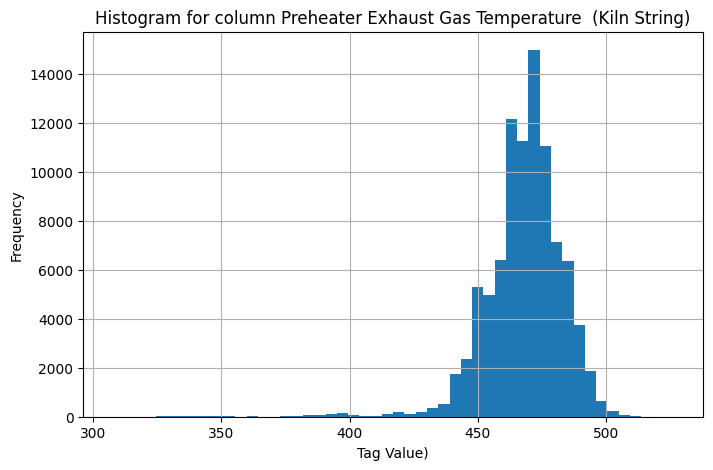

In [12]:


script_dir = os.getcwd()
# Define subdirectories relative to the script's location
hist_dir = os.path.join(script_dir, "histograms")
box_dir = os.path.join(script_dir, "boxplots")

for col in df_cleaned.columns:
    # Create those directories if they don't exist
    os.makedirs(hist_dir, exist_ok=True)
    os.makedirs(box_dir, exist_ok=True)
    
    # Histogram for Tag_Value
    plt.figure(figsize=(8, 5))
    # df[df['tag_value'].between(0, 3000)]['tag_value'].hist(bins=50)
    df_cleaned[col].hist(bins=50)
    plt.title(f"Histogram for column {col}")
    plt.xlabel(f"Tag Value)")
    plt.ylabel("Frequency")
    # safe_col_name = col.replace('/', '_').replace('\\', '_')
    # filename = os.path.join(hist_dir, f"{safe_col_name}_histogram.png")
    plt.savefig(os.path.join(hist_dir, f"{col}_histogram.png"))
    # plt.savefig(f"histograms/Tag_{tag_id}_histogram.png")
    plt.close()
    
    # Boxplot for Tag_Value
    plt.figure(figsize=(6, 8))
    plt.boxplot(df_cleaned[col].dropna(), vert=True)
    plt.title(f"Boxplot for column {col}")
    plt.ylabel(f"Tag Value")
    plt.savefig(os.path.join(box_dir, f"{col}_boxplot.png"))
    # plt.savefig(f"boxplots/Tag_{tag_id}_boxplot.png")
    plt.close()

Time Lagging data for clinker temp prediction

In [13]:
# lag mapping dictionary
lag_mapping = {'Clinker temperature' : 
               {'Feed': 35,
                'PH exhaust': 0,
                'Bottom cone': 25,
                'Calciner': 22,
                'Kiln inlet': 18,
                'Kiln main': 16,
                'Kiln end': 7,
                'Cooler': 4,
                'TA duct': -3,}, 

                'Calciner Outlet-1 CO (SLC)': 
                {'Feed': 10,
                'PH exhaust': 0,
                'Bottom cone': 3,
                'Calciner': 0,
                'Kiln inlet': 0,
                'Kiln main': 0,
                'Kiln end': 0,
                'Cooler': 0,
                'TA duct': -25,}, 

                'Calciner Outlet-1 O2 (SLC)': 
                {'Feed': 10,
                'PH exhaust': 0,
                'Bottom cone': 3,
                'Calciner': 0,
                'Kiln inlet': 0,
                'Kiln main': 0,
                'Kiln end': 0,
                'Cooler': 0,
                'TA duct': -25,}, 


               'Kiln inlet Temperature': 
               {'Feed': 17,
                'PH exhaust': 0,
                'Bottom cone': 7,
                'Calciner': 4,
                'Kiln inlet': 0,
                'Kiln main': 0,
                'Kiln end': -10,
                'Cooler': -5,
                'TA duct': 0,}, 

               'Kiln Inlet O2': 
               {'Feed': 17,
                'PH exhaust': 0,
                'Bottom cone': 7,
                'Calciner': 4,
                'Kiln inlet': 0,
                'Kiln main': 0,
                'Kiln end': -10,
                'Cooler': -5,
                'TA duct': 0}, 
               
               'Kiln Inlet CO' : 
               {'Feed': 17,
                'PH exhaust': 0,
                'Bottom cone': 7,
                'Calciner': 4,
                'Kiln inlet': 0,
                'Kiln main': 0,
                'Kiln end': -10,
                'Cooler': -5,
                'TA duct': 0}, 
                
                'Preheater Exhaust Gas Temperature (SLC)' : 
                {'Feed': 40,
                'PH exhaust': 0,
                'Bottom cone': 7,
                'Calciner': 10,
                'Kiln inlet': 12,
                'Kiln main': 15,
                'Kiln end': 20,
                'Cooler': 35,
                'TA duct': 25}, 

               'Secondary Air Temperature': 
               {'Feed': 35,
                'PH exhaust': 0,
                'Bottom cone': 22,
                'Calciner': 20,
                'Kiln inlet': 15,
                'Kiln main': 13,
                'Kiln end': 5,
                'Cooler': 0,
                'TA duct': 0,},

}

Attempting to create automated pipeline

In [14]:
cur.execute("SELECT description_2, site FROM master_table WHERE tag_id < 81")
rows = cur.fetchall()
# Build: {column_name: lag_in_minutes}

feature_dict = {}
lagged_df = {}
for key,value in lag_mapping.items():
    print(key)
    col_lags = {desc: value.get(site, 0) for desc, site in rows}

    df_lagged = df.copy()
    for col in df.columns:
        lag_min = col_lags.get(col, 0)
        if col == key:
            continue
        if lag_min != 0:
            df_lagged[col] = df[col].shift(freq=pd.Timedelta(minutes=lag_min))

    # Step 3: Drop initial rows with NaN from shift
    df_lagged.dropna(inplace=True)
    lagged_df[key] = df_lagged

# Store correlations
    results = []

    for col in df_lagged.columns:
        pearson_corr, _ = stats.pearsonr(df_lagged[key], df_lagged[col])
        spearman_corr, _ = stats.spearmanr(df_lagged[key], df_lagged[col])

        results.append({
            'feature': col,
            'pearson': pearson_corr,
            'spearman': spearman_corr
        })

    # Convert to DataFrame
    corr_df_pearson = pd.DataFrame(results).sort_values(by='pearson', ascending=False)
    corr_df_spearman = pd.DataFrame(results).sort_values(by='spearman', ascending=False)

# Mutual Information

    X = df_lagged.drop(columns=key)
    Y = df_lagged[key]

    mi_scores = mutual_info_regression(X, Y, random_state=0)
    # Wrap in DataFrame
    mi_df = pd.DataFrame({
        'feature': X.columns,
        'mutual_info': mi_scores
    }).sort_values(by='mutual_info', ascending=False)

# Random Forest Feature Importance

    X = df_lagged.drop(columns=key)
    Y = df_lagged[key]

    model = RandomForestRegressor()
    model.fit(X, Y)

    RF_df = pd.DataFrame({
        'feature': X.columns,
        'feature_imp': model.feature_importances_
    }).sort_values(by='feature_imp', ascending=False)    

# get the common features from all the three methods

    # Merge all feature names into sets
    features_db1 = corr_df_pearson.head(20)['feature'].tolist()
    features_db2 = corr_df_spearman.head(20)['feature'].tolist()
    features_db3 = mi_df.head(20)['feature'].tolist()
    features_db4 = RF_df.head(20)['feature'].tolist()

    # Step 2: Count occurrences across all three top lists
    from collections import Counter

    # Flatten the lists into one and count occurrences
    all_top_features = features_db1 + features_db2 + features_db3 + features_db4
    feature_counts = Counter(all_top_features)

    # Step 3: Keep only features that appear in at least 2 lists
    final_features = [feature for feature, count in feature_counts.items() if count >= 2]

    final_df = pd.DataFrame(final_features, columns=['feature'])[:20]

    feature_dict[key] = final_df



Clinker temperature
Calciner Outlet-1 CO (SLC)
Calciner Outlet-1 O2 (SLC)
Kiln inlet Temperature
Kiln Inlet O2
Kiln Inlet CO
Preheater Exhaust Gas Temperature (SLC)
Secondary Air Temperature


In [ ]:
for key, value in feature_dict.items():
    print(f"Key: {key}")
    print("Value:")
    print(value)
    print("\n")

Key: Clinker temperature
Value:
                                             feature
0                                Clinker temperature
1                                          A54 Draft
2                              Cooler Fan-3 Pressure
3                                          C56 Draft
4                              Cooler Fan-4 Pressure
5                              Tower pressure (mmwg)
6                                    Stroke Speed PV
7   Preheater Exhaust Gas Temperature  (Kiln String)
8                         Calciner Outlet-1 CO (SLC)
9                                 Kiln Feed PV (ILC)
10                                         B54 Draft
11                                PH Fan Speed (SLC)
12        A54 Temperature (Bottom cone_ Kiln string)
13                             Cooler Fan-2 Pressure
14                               Kiln Coal Feed Rate
15                             Cooler Fan-5 Pressure
16                     Calciner_temperature_PV (ILC)
17            

In [ ]:
"""let 35 mins be the time taken from the start of the process to the end of the process.
Break the variables into its different sites and give them lags accordingly. This is a uplicate of
the above code but for only clinker temperature. this was in the trial phase of development."""

# create a lag mapping based on domain knowledge
lag_mapping = {
    'Feed': 35,
    'PH exhaust': 0,
    'Bottom cone': 25,
    'Calciner': 22,
    'Kiln inlet': 18,
    'Kiln main': 16,
    'Kiln end': 7,
    'Cooler': 4,
    'TA duct': -3,
}

# Build: {column_name: lag_in_minutes}
cur.execute("SELECT description_2, site FROM master_table WHERE tag_id < 81")
rows = cur.fetchall()
col_lags = {desc: lag_mapping.get(site, 0) for desc, site in rows}

# Step 2: Apply time-based lags using datetime-aware shift
df_lagged = df.copy()
for col in df.columns:
    lag_min = col_lags.get(col, 0)
    if col == 'Clinker temperature':
        continue
    if lag_min != 0:
        df_lagged[col] = df[col].shift(freq=pd.Timedelta(minutes=lag_min))

# Step 3: Drop initial rows with NaN from shift
df_lagged.dropna(inplace=True)

df_lagged

Specific Air consumption  Clinker temperature  \
time_stamp                                                           
2025-01-01 13:30:00                      9.04                103.0   
2025-01-01 13:31:00                      8.94                105.0   
2025-01-01 13:32:00                      9.01                105.0   
2025-01-01 13:33:00                      8.06                103.0   
2025-01-01 13:34:00                      8.24                102.0   
...                                       ...                  ...   
2025-03-11 23:52:00                      2.01                148.0   
2025-03-11 23:53:00                      2.01                147.0   
2025-03-11 23:54:00                      2.01                147.0   
2025-03-11 23:55:00                      2.00                147.0   
2025-03-11 23:56:00                      2.00                147.0   

                     Secondary Air Temperature  Kiln Hood Draft temperature  \
time_stamp                                                                    
2025-01-01 13:30:00                      440.0                        -9.69   
2025-01-01 13:31:00                      448.0                        -9.89   
2025-01-01 13:32:00                      456.0                       -10.02   
2025-01-01 13:33:00                      464.0                       -10.09   
2025-01-01 13:34:00                      472.0                       -10.32   
...                                        ...                          ...   
2025-03-11 23:52:00                      917.0                        -2.25   
2025-03-11 23:53:00                      921.0                        -0.21   
2025-03-11 23:54:00                      925.0                        -1.75   
2025-03-11 23:55:00                      929.0                        -1.85   
2025-03-11 23:56:00                      933.0                        -2.69   

                     TA Duct Draft  TA Duct Temperature  \
time_stamp                                                
2025-01-01 13:30:00            1.0                666.0   
2025-01-01 13:31:00            1.0                665.0   
2025-01-01 13:32:00            1.0                666.0   
2025-01-01 13:33:00            1.0                671.0   
2025-01-01 13:34:00            1.0                677.0   
...                            ...                  ...   
2025-03-11 23:52:00            0.0               1085.0   
2025-03-11 23:53:00            0.0               1087.0   
2025-03-11 23:54:00            0.0               1088.0   
2025-03-11 23:55:00            0.0               1090.0   
2025-03-11 23:56:00            0.0               1091.0   

                     Cooler vent Fan Speed (Cooler outlet Fan_ ESP Inlet Fan) PV  \
time_stamp                                                                         
2025-01-01 13:30:00                                               85.0             
2025-01-01 13:31:00                                               85.0             
2025-01-01 13:32:00                                               85.0             
2025-01-01 13:33:00                                               85.0             
2025-01-01 13:34:00                                               85.0             
...                                                                ...             
2025-03-11 23:52:00                                               95.0             
2025-03-11 23:53:00                                               95.0             
2025-03-11 23:54:00                                               94.0             
2025-03-11 23:55:00                                               94.0             
2025-03-11 23:56:00                                               94.0             

                     Coal Feed Rate (Calciner String)  Kiln Coal Feed Rate  \
time_stamp                                                                   
2025-01-01 13:30:00                              9.61            

create scatter plots

In [ ]:
script_dir = os.getcwd()
parent_dir = os.path.join(script_dir, "Time_lagged")
os.makedirs(parent_dir, exist_ok=True)

scatter_dir = os.path.join(parent_dir, f"Scatterplot_ClinkerTemp")
os.makedirs(scatter_dir, exist_ok=True)
for col in df_lagged.columns:
    # if col != target_tag:
    plt.figure(figsize=(8, 5))
    plt.scatter(df_lagged['Clinker temperature'], df_lagged[col], alpha=0.5)
    plt.title(f"Scatter plot of ClinkerTemp vs {col}")
    plt.xlabel('ClinkerTemp')
    plt.ylabel(col)
    plt.savefig(os.path.join(scatter_dir, f"ClinkerTemp_vs_{col}.png"))
    plt.close()

create corelation metrics

In [ ]:
correlation_dir = os.path.join(parent_dir, f"Correlation_CLinkerTemp")
os.makedirs(correlation_dir, exist_ok=True)
# Store correlations
results = []

for col in df_lagged.columns:
    pearson_corr, _ = stats.pearsonr(df_lagged['Clinker temperature'], df_lagged[col])
    spearman_corr, _ = stats.spearmanr(df_lagged['Clinker temperature'], df_lagged[col])

    results.append({
        'feature': col,
        'pearson': pearson_corr,
        'spearman': spearman_corr
    })

# Convert to DataFrame
corr_df_pearson = pd.DataFrame(results).sort_values(by='pearson', ascending=False)
corr_df_spearman = pd.DataFrame(results).sort_values(by='spearman', ascending=False)

corr_df_pearson.head()
# # Save to CSV
# corr_df_pearson.to_csv(os.path.join(correlation_dir, f"Clinker_temperature_correlations.csv"), index=False)

# # Plot top N strongest Pearson correlations
# top_n = 20
# top_corrs_P = corr_df_pearson.set_index('tag').iloc[:top_n]

# plt.figure(figsize=(10, 6))
# top_corrs_P['pearson'].plot(kind='barh', color='skyblue')
# plt.xlabel("Pearson Correlation with Target")
# plt.title(f"Top {top_n} Pearson Correlations: Clinker temperature")
# plt.gca().invert_yaxis()
# plt.tight_layout()
# plt.savefig(os.path.join(correlation_dir, f"Clinker temperature_top_{top_n}_pearson.png"))
# plt.close()

# # Plot top N strongest Spearman correlations
# top_n = 20
# top_corrs_S = corr_df_spearman.set_index('tag').iloc[:top_n]

# plt.figure(figsize=(10, 6))
# top_corrs_S['spearman'].plot(kind='barh', color='skyblue')
# plt.xlabel("Spearman Correlation with Target")
# plt.title(f"Top {top_n} Spearman Correlations: Clinker temperature")
# plt.gca().invert_yaxis()
# plt.tight_layout()
# plt.savefig(os.path.join(correlation_dir, f"Clinker temperature_top_{top_n}_spearman.png"))
# plt.close()

feature   pearson  spearman
1     Clinker temperature  1.000000  1.000000
22              A54 Draft  0.241856  0.231674
42  Cooler Fan-3 Pressure  0.199202  0.177931
24              C56 Draft  0.196374  0.174445
43  Cooler Fan-4 Pressure  0.181179  0.159608

Mutual info analysis

In [ ]:
mi_dir = os.path.join(parent_dir, f"Clinker_temperature_mutual_info")
os.makedirs(mi_dir, exist_ok=True)

X = df_lagged.drop(columns='Clinker temperature')
Y = df_lagged['Clinker temperature']

mi_scores = mutual_info_regression(X, Y, random_state=0)
# Wrap in DataFrame
mi_df = pd.DataFrame({
    'feature': X.columns,
    'mutual_info': mi_scores
}).sort_values(by='mutual_info', ascending=False)

# Save results
mi_df.to_csv(os.path.join(mi_dir, f"Clinker temperature_mi_scores.csv"), index=False)

mi_df.head()

# # Plot top N features
# top_n = 20
# top_mi = mi_df.head(top_n).set_index('feature')

# plt.figure(figsize=(10, 6))
# top_mi['mutual_info'].plot(kind='barh', color='salmon')
# plt.xlabel("Mutual Information with Target")
# plt.title(f"Top {top_n} Mutual Info Features: Clinker temperature")
# plt.gca().invert_yaxis()
# plt.tight_layout()
# plt.savefig(os.path.join(mi_dir, f"Clinker temperature_top_{top_n}_mi.png"))
# plt.close()


feature  mutual_info
10  Kiln inlet Temperature     0.355644
56      PH Fan Speed (ILC)     0.320796
45   Cooler Fan-7 Pressure     0.289856
31      Cooler Fan 14 Flow     0.249631
17       Diverter position     0.233751

feature selection using RF

In [ ]:
RF_dir = os.path.join(parent_dir, f"Clinker temperature_feature_importance")
os.makedirs(RF_dir, exist_ok=True)

X = df_lagged.drop(columns='Clinker temperature')
Y = df_lagged['Clinker temperature']

model = RandomForestRegressor()
model.fit(X, Y)

RF_df = pd.DataFrame({
    'feature': X.columns,
    'feature_imp': model.feature_importances_
}).sort_values(by='feature_imp', ascending=False)

RF_df.head()

# RF_df.to_csv(os.path.join(RF_dir, f"Clinker temperature_feature_importance.csv"), index=False)

# # Plot top N features
# top_n = 20
# top_feat = RF_df.head(top_n).set_index('feature')

# plt.figure(figsize=(10, 6))
# top_feat['feature_imp'].plot(kind='barh', color='salmon')
# plt.xlabel("Feat_imp to Target")
# plt.title(f"{top_n} Features Influencing Clinker temperature")
# plt.gca().invert_yaxis()
# plt.tight_layout()
# plt.savefig(os.path.join(RF_dir, f"Clinker temperature_top_{top_n}_mi.png"))
# plt.close()


feature  feature_imp
25                                Cooler Fan 10 Flow     0.116438
44                             Cooler Fan-6 Pressure     0.098678
17                                 Diverter position     0.056267
56                                PH Fan Speed (ILC)     0.048720
58  Preheater Exhaust Gas Temperature  (Kiln String)     0.048061

In [ ]:
# Merge all feature names into sets
features_db1 = corr_df_pearson.head(20)['feature'].tolist()
features_db2 = corr_df_spearman.head(20)['feature'].tolist()
features_db3 = mi_df.head(20)['feature'].tolist()
features_db4 = RF_df.head(20)['feature'].tolist()

# Step 2: Count occurrences across all three top lists
from collections import Counter

# Flatten the lists into one and count occurrences
all_top_features = features_db1 + features_db2 + features_db3 + features_db4
feature_counts = Counter(all_top_features)

# Step 3: Keep only features that appear in at least 2 lists
final_features = [feature for feature, count in feature_counts.items() if count >= 2]

final_df = pd.DataFrame(final_features, columns=['feature'])[:20]

print("Top unique features (appearing in at least 2 metrics):")
print(final_df)


Top unique features (appearing in at least 2 metrics):
                                             feature
0                                Clinker temperature
1                                          A54 Draft
2                              Cooler Fan-3 Pressure
3                                          C56 Draft
4                              Cooler Fan-4 Pressure
5                              Tower pressure (mmwg)
6                                    Stroke Speed PV
7   Preheater Exhaust Gas Temperature  (Kiln String)
8                         Calciner Outlet-1 CO (SLC)
9                                 Kiln Feed PV (ILC)
10                                         B54 Draft
11                                PH Fan Speed (SLC)
12        A54 Temperature (Bottom cone_ Kiln string)
13                             Cooler Fan-2 Pressure
14                               Kiln Coal Feed Rate
15                             Cooler Fan-5 Pressure
16                     Calciner_temperature_

# Feature Engineering

In [ ]:
Target_tags = ['Calciner Outlet-1 CO (SLC)', 'Calciner Outlet-1 O2 (SLC)', 
               'Kiln inlet Temperature', 'Kiln Drive Current (Torque)', 
               'Kiln Inlet O2', 'Kiln Inlet CO', 'Preheater Exhaust Gas Temperature (SLC)', 
               'Secondary Air Temperature', 'Clinker temperature']


script_dir = os.getcwd()

In [ ]:
# Plotting scatter plot for one target variable agaisnt other tags

parent_dir = os.path.join(script_dir, "scatterplot")
os.makedirs(parent_dir, exist_ok=True)

for tag in Target_tags:
    scatter_dir = os.path.join(parent_dir, f"{tag} Scatterplots_df")
    os.makedirs(scatter_dir, exist_ok=True)
    for col in df.columns:
        # if col != target_tag:
        plt.figure(figsize=(8, 5))
        plt.scatter(df[tag], df[col], alpha=0.5)
        plt.title(f"Scatter plot of {tag} vs {col}")
        plt.xlabel(tag)
        plt.ylabel(col)
        plt.savefig(os.path.join(scatter_dir, f"{tag}_vs_{col}.png"))
        plt.close()



In [ ]:
# To find pearson and spearman correlation between the target variable and other tags
# and save the results in a csv file

parent_dir = os.path.join(script_dir, "corelation")
os.makedirs(parent_dir, exist_ok=True)

for tag in Target_tags:
    correlation_dir = os.path.join(parent_dir, f"{tag} Correlation")
    os.makedirs(correlation_dir, exist_ok=True)
    # Store correlations
    results = []

    for col in df.columns:
        pearson_corr, _ = stats.pearsonr(df[tag], df[col])
        spearman_corr, _ = stats.spearmanr(df[tag], df[col])

        results.append({
            'tag': col,
            'pearson': pearson_corr,
            'spearman': spearman_corr
        })

    # Convert to DataFrame
    corr_df_pearson = pd.DataFrame(results).sort_values(by='pearson', ascending=False)
    corr_df_spearman = pd.DataFrame(results).sort_values(by='spearman', ascending=False)

    # Save to CSV
    corr_df_pearson.to_csv(os.path.join(correlation_dir, f"{tag}_correlations.csv"), index=False)

    # Plot top N strongest Pearson correlations
    top_n = 20
    top_corrs_P = corr_df_pearson.set_index('tag').iloc[:top_n]

    plt.figure(figsize=(10, 6))
    top_corrs_P['pearson'].plot(kind='barh', color='skyblue')
    plt.xlabel("Pearson Correlation with Target")
    plt.title(f"Top {top_n} Pearson Correlations: {tag}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(os.path.join(correlation_dir, f"{tag}_top_{top_n}_pearson.png"))
    plt.close()

    # Plot top N strongest Spearman correlations
    top_n = 20
    top_corrs_S = corr_df_spearman.set_index('tag').iloc[:top_n]

    plt.figure(figsize=(10, 6))
    top_corrs_S['spearman'].plot(kind='barh', color='skyblue')
    plt.xlabel("Spearman Correlation with Target")
    plt.title(f"Top {top_n} Spearman Correlations: {tag}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(os.path.join(correlation_dir, f"{tag}_top_{top_n}_spearman.png"))
    plt.close()


In [ ]:
# Feature importance using Random Forest

parent_dir = os.path.join(script_dir, "feature_selection_RF")
os.makedirs(parent_dir, exist_ok=True)

for tag in Target_tags:
    RF_dir = os.path.join(parent_dir, f"{tag} feature_importance")
    os.makedirs(RF_dir, exist_ok=True)
    
    X = df.drop(columns=[tag])
    Y = df[tag]

    model = RandomForestRegressor()
    model.fit(X, Y)

    RF_df = pd.DataFrame({
        'feature': X.columns,
        'feature_imp': model.feature_importances_
    }).sort_values(by='feature_imp', ascending=False)

    RF_df.to_csv(os.path.join(RF_dir, f"{tag}_feature_importance.csv"), index=False)

    # Plot top N features
    top_n = 20
    top_feat = RF_df.head(top_n).set_index('feature')

    plt.figure(figsize=(10, 6))
    top_feat['feature_imp'].plot(kind='barh', color='salmon')
    plt.xlabel("Feat_imp to Target")
    plt.title(f"{top_n} Features Influencing {tag}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(os.path.join(RF_dir, f"{tag}_top_{top_n}_mi.png"))
    plt.close()


KeyboardInterrupt: 

In [ ]:

parent_dir = os.path.join(script_dir, "mutual_info")
os.makedirs(parent_dir, exist_ok=True)

for tag in Target_tags:
    mi_dir = os.path.join(parent_dir, f"{tag} mutual_info")
    os.makedirs(mi_dir, exist_ok=True)

    X = df.drop(columns=[tag])
    Y = df[tag]

    mi_scores = mutual_info_regression(X, Y, random_state=0)
    # Wrap in DataFrame
    mi_df = pd.DataFrame({
        'feature': X.columns,
        'mutual_info': mi_scores
    }).sort_values(by='mutual_info', ascending=False)

    # Save results
    mi_df.to_csv(os.path.join(mi_dir, f"{tag}_mi_scores.csv"), index=False)

    # Plot top N features
    top_n = 20
    top_mi = mi_df.head(top_n).set_index('feature')

    plt.figure(figsize=(10, 6))
    top_mi['mutual_info'].plot(kind='barh', color='salmon')
    plt.xlabel("Mutual Information with Target")
    plt.title(f"Top {top_n} Mutual Info Features: {tag}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(os.path.join(mi_dir, f"{tag}_top_{top_n}_mi.png"))
    plt.close()


# preparing data to pass into model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows

# Use min-max normalization 
scaler = MinMaxScaler()

data = {}
output_file = "Modified_Feature_Sets.xlsx"
writer = pd.ExcelWriter(output_file, engine='openpyxl')
for key, final_df in feature_dict.items():
    # Get the required columns from the lagged DataFrame

    required_columns = final_df['feature'].tolist()
    print(key)

    # Filter the DataFrame to include only the required columns
    df_filtered = lagged_df[key][required_columns].dropna()

    train_df, test_df = train_test_split(df_filtered, test_size=0.2, random_state=42)

    X_train, y_train  = train_df[required_columns[1:]].values, train_df[required_columns[0]].values
    X_test, y_test  = test_df[required_columns[1:]].values, test_df[required_columns[0]].values 

    X_train_normalized = scaler.fit_transform(X_train) 

    X_test_scaled = scaler.transform(X_test)

    # Step 4: Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # reshape to (n_samples, 1)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)  # reshape to (n_samples, 1)

    # Optional: wrap in a TensorDataset for training
    from torch.utils.data import TensorDataset, DataLoader

    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_data, batch_size=5000, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

    data[key] = (train_loader, test_loader)

writer.close()



Clinker temperature
Calciner Outlet-1 CO (SLC)
Calciner Outlet-1 O2 (SLC)
Kiln inlet Temperature
Kiln Inlet O2
Kiln Inlet CO
Preheater Exhaust Gas Temperature (SLC)
Secondary Air Temperature


# Model Architecture

In [16]:

class MLPModel(nn.Module):
    def __init__(self, input_dim = 19, num_hidden=100):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_hidden)
        self.fc2 = nn.Linear(num_hidden, 60)
        self.fc3 = nn.Linear(60, 20)
        self.fc4 = nn.Linear(20, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x


# Model Training

In [37]:
def train_model(model,                # an instance of MLPModel
                train_loader,           # training data
                test_loader,             # validation data
                key,
                suffix,
                save_dir='plots',
                learning_rate=0.001,
                batch_size=32,
                num_epochs=500,
                plot_every=50,        # how often (in # iterations) to track metrics
                plot=True,
                results=None,
                features_used = None):           # whether to plot the training curve
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    os.makedirs(save_dir, exist_ok=True)


    # these lists will be used to track the training progress
    # and to plot the training curve
    iters, train_loss, test_loss = [], [], []
    iter_count = 0 # count the number of iterations that has passed

    try:
        for e in range(num_epochs):
            for i, (tags, labels) in enumerate(train_loader):
                z = model(tags)
                # print(type(z), type(labels))
                # break
                loss = torch.sqrt(criterion(z, labels)) # TODO

                loss.backward() # propagate the gradients
                optimizer.step() # update the parameters
                optimizer.zero_grad() # clean up accumualted gradients

                iter_count += 1
                if iter_count % plot_every == 0:
                    iters.append(iter_count)
                    # ta = accuracy(model, train_data)
                    # va = accuracy(model, val_data)
                    train_loss.append(float(loss))
                    # train_acc.append(ta)
                    # val_acc.append(va)
                    print(iter_count, "Loss:", float(loss))

        final_loss = float(loss)

    finally:
        # This try/finally block is to display the training curve
        # even if training is interrupted
        if plot:
            plt.figure()
            plt.plot(iters[:len(train_loss)-3], train_loss[3:])
            # plt.plot(iters[:len(test_loss)], test_loss)
            # plt.legend(["Train", "Test"])
            plt.title(f"RMSE Loss over iterations for {key}_{suffix} ")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")
            plot_path = os.path.join(save_dir, f"{key}_{suffix}.png")
            plt.savefig(plot_path)
            plt.close()
        
        if results is not None and features_used is not None:
            results.append([features_used, final_loss])

output_file = "Modified_Feature_Sets.xlsx"
writer = pd.ExcelWriter(output_file, engine='openpyxl', mode='a', if_sheet_exists='overlay')

results = []
for key, (train_loader, test_loader) in data.items():
    print(key)
    model = MLPModel()
    required_columns = feature_dict[key]['feature'].tolist()

    # if key == 'Clinker temperature':
    #     required_columns[1:8] = ['Cooler Fan 12 Flow', 'Cooler Fan 13 Flow', 'Cooler Fan 14 Flow', 'Cooler Fan 15 Flow', 'Cooler Fan 16 Flow', 'Cooler Fan 17 Flow', 'Cooler vent Fan Speed (Cooler outlet Fan_ ESP Inlet Fan) PV']
    #     required_columns[10] = 'Specific Air consumption'
    #     required_columns[13] = 'Calciner Coal Feed Rate (ILC)'
    #     required_columns[15] = 'Secondary Air Temperature'
    #     required_columns[18] = 'Vessel_Calciner_temperature_PV (SLC)'
    #     required_columns[11] = 'TA Duct Temperature'

    # elif key == 'Calciner Outlet-1 CO (SLC)':
    #     required_columns[19] = 'B54 Draft'
    #     required_columns[4:7] = ['Calciner Outlet-1 O2 (SLC)', 'Coal Feed Rate (Calciner String)', 'Kiln Feed PV (SLC)']
    #     required_columns[9:11] =  ['TA Duct Temperature', 'Tower pressure (mmwg)']

    # elif key == 'Calciner Outlet-1 O2 (SLC)':
    #     required_columns[12:18] = ['B54 Draft', 'Calciner Outlet-1 CO (SLC)', 'Kiln Feed PV (SLC)', 
    #     'TA Duct Temperature', 'Tower pressure (mmwg)', 'Vessel_Calciner_temperature_PV (SLC)']
    #     required_columns[6], required_columns[10]  = 'A54 Temperature (Bottom cone_ Kiln string)', 'A54 Draft'

    # elif key == 'Kiln inlet Temperature':
    #     required_columns[3:5] = ['Kiln Coal Feed Rate', 'Kiln Hood Draft temperature']
    #     required_columns[9] = 'Kiln Feed PV (Kiln String)'
    #     required_columns[16] = 'Calciner_temperature_PV (ILC)'
    #     required_columns[18:20] = ['Kiln Feed PV (SLC)', 'Kiln Feed PV (ILC)']
       
    # elif key == 'Kiln Inlet O2':
    #     required_columns[11:16] = ['Kiln Outlet CO (Kiln string)', 
    #                             'Kiln Outlet O2 (Kiln string)', 'PH Fan Speed (SLC)',
    #                                 'PH Fan Speed  (Kiln String)', 'PH Fan Speed (ILC)']
    #     required_columns[17:19] = ['Preheater Exhaust Gas Temperature  (Kiln String)', 
    #                             'Kiln Hood Draft temperature']
        
    # elif key == 'Kiln Inlet CO':
    #     required_columns[5] , required_columns[11], required_columns[15] = 'Tower pressure (mmwg)', 'Kiln Hood Draft temperature', 'Kiln Outlet O2 (Kiln string)'
        
    # elif key == 'Preheater Exhaust Gas Temperature (SLC)':
    #     required_columns[4] = 'Kiln Feed PV (SLC)' 
    #     required_columns[9:11] = ['Kiln Outlet O2 (Kiln string)', 'Kiln Hood Draft temperature']
    #     required_columns[13:15] = ['Kiln Coal Feed Rate', 'TA Duct Temperature']
    #     required_columns[18:20] = ['Coal Feed Rate (Calciner String)', 'Secondary Air Temperature']
        
    # elif key == 'Secondary Air Temperature':
    #     required_columns[1], required_columns[3], required_columns[5] = 'Cooler Fan 10 Flow', 'Cooler Fan 12 Flow', 'Cooler Fan 13 Flow'
    #     required_columns[7:11] = ['Cooler Fan 14 Flow', 'Cooler vent Fan Speed (Cooler outlet Fan_ ESP Inlet Fan) PV', 'Calciner_temperature_PV (ILC)', 'Kiln inlet Temperature']
    #     required_columns[16:18] = ['C56 Temperature (Bottom cone_ ILC string)', 'A54 Temperature (Bottom cone_ Kiln string)']
    #     required_columns[19] = 'Vessel_Calciner_temperature_PV (SLC)'
        
    
    train_model(model, train_loader, test_loader, key, suffix='original',
                    results=results, features_used=required_columns,)
    
    df_results = pd.DataFrame(results, columns=["Features_Original", "Final Loss"])
    df_results.to_excel(writer, sheet_name=key[:31], index=False, startrow=0)
writer.close()


Clinker temperature
50 Loss: 148.4420928955078
100 Loss: 77.90135955810547
150 Loss: 30.22442626953125
200 Loss: 30.374835968017578
250 Loss: 30.793415069580078
300 Loss: 30.715988159179688
350 Loss: 29.880290985107422
400 Loss: 29.563310623168945
450 Loss: 29.277345657348633
500 Loss: 29.247922897338867
550 Loss: 28.727983474731445
600 Loss: 28.558748245239258
650 Loss: 28.286516189575195
700 Loss: 27.95584487915039
750 Loss: 27.768354415893555
800 Loss: 27.716428756713867
850 Loss: 26.99855613708496
900 Loss: 27.6889591217041
950 Loss: 27.35199546813965
1000 Loss: 26.729700088500977
1050 Loss: 26.861106872558594
1100 Loss: 26.07910919189453
1150 Loss: 26.446537017822266
1200 Loss: 26.464237213134766
1250 Loss: 25.83392333984375
1300 Loss: 25.83759880065918
1350 Loss: 25.291231155395508
1400 Loss: 25.321407318115234
1450 Loss: 25.403419494628906
1500 Loss: 24.95958709716797
1550 Loss: 25.623743057250977
1600 Loss: 25.224103927612305
1650 Loss: 24.950502395629883
1700 Loss: 25.04166603